In [2]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12470726627113544064
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5235607361765387142
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18410676439630112429
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [14]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [8]:
data_train = getData(Files[0],['lfp','speed'],period ='Pre', mice=mTrain)
# data_validate = getData(Files[0],['lfp','speed'],period ='Pre', mice=mValidate)
data_test = getData(Files[0],['lfp','speed'],period ='Pre', mice=mTest)

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data


In [15]:
def prepData(segN,overlap,df):
    df2 = df
    df2['start'] = pd.Series([[]] * len(df2), index=df2.index)
    df2['end'] = pd.Series([[]] * len(df2), index=df2.index)
    for l in df.length.unique():
        a = np.asarray([[i,i + segN] for i in range(0, l-(segN-overlap),int(segN-overlap))])
        df2.loc[df2.length==l,'start'] = pd.Series([a[:,0]] * len(df2), index=df2.index)
        df2.loc[df2.length==l,'end'] =  pd.Series([a[:,1]] * len(df2), index=df2.index)
    lst_col = 'start'

    lst_col = 'start'
    lst_col2 = 'end'
    df3 = pd.DataFrame({
        col:np.repeat(df2[col].values, df2['start'].str.len())
        for col in df2.columns.difference(['start','end'])
    }).assign(**{'start':np.concatenate(df2['start'].values)}).assign(**{'end':np.concatenate(df2['end'].values)})[df2.columns.tolist()]
    return df3

In [18]:
miceList = getMiceList(Files[0])
miceList.remove('1253')
miceList.remove('1231')
mOrder = np.random.permutation(len(miceList))

mTrain = [1231, 1253]
mTest =[int(miceList[i]) for i in mOrder[:2]]
mTrain = mTrain+ [int(miceList[i]) for i in mOrder[2:]]

print(mTrain,mTest)
# print(miceList[mOrder[:2]])

[1231, 1253, 8815, 1208, 2981, 1222, 2976, 7909, 4539, 1793, 8803, 7584, 2980, 8430] [1236, 761]


In [19]:
df = pd.read_csv('availableData2.csv')  
# try 30s with 20s overlab
dtL = 0.0032768
segN = int(np.ceil(15/dtL))
overlap = int(np.ceil(3/dtL))
dataSamples = prepData(segN,overlap,df)

df = prepData(segN,overlap,df)
testData = df[df.Mouse.isin(mTest)]
trainData = df[df.Mouse.isin(mTrain)]
validate = trainData.sample(frac=.1)
trainData = trainData.drop(validate.index)

In [16]:
def loadTrain(data,sampleSize):
    f = h5py.File('E:\\rawLFPData2.hdf5','r')
    data['Period'] = data.Period.apply(lambda x: 'Healthy' if x=='Healthy' else  'sick' )
    # sampleSize = batchSize/3
    while True: 
        batch = data.groupby('Period').apply(lambda x: x.sample(sampleSize))
        batch = batch.sample(frac=1)
        labels = batch.Period.apply(lambda x: [1,0] if x=='Healthy' else  [0,1]  )
        labels = np.stack(labels.values)
        dataPoint = batch.apply(lambda row: f[row.Session][:,row.start:row.end].T, axis=1).values
        try:
            dataPoint = np.stack(dataPoint)
        except:
            continue
        yield (dataPoint,labels)
    f.close()


In [17]:
def loadTest(data):
    f = h5py.File('E:\\rawLFPData2.hdf5','r')
    # sampleSize = batchSize/3 
    for i, g in data.groupby(np.arange(len(data)) // 9):
        batch = g
        labels = batch.Period.apply(lambda x: [1,0] if x=='Healthy' else  [0,1] )
        labels = np.stack(labels.values)
        dataPoint = batch.apply(lambda row: f[row.Session][:,row.start:row.end].T, axis=1).values
        try:
            dataPoint = np.stack(dataPoint)
        except:
            continue
        yield (dataPoint,labels)
    f.close()


In [21]:
for ind,(dataP,label) in enumerate(loadTest(testData)):
    print(np.max(dataP[3,:,:],axis=0))
    if ind == 1:
        break

[0.78273906 0.28923555]
[0.76908022 0.14689967]


In [22]:
for ind,(dataP,label) in enumerate(loadTrain(trainData,3)):
    print(label.shape,dataP.shape)
    if ind == 3:
        break

(6, 2) (6, 4578, 2)
(6, 2) (6, 4578, 2)
(6, 2) (6, 4578, 2)
(6, 2) (6, 4578, 2)


In [39]:
model =  tf.keras.models.load_model('E:\\rawLFP_v5n_tunning_binary')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# model.load_weights("E:\\rawLFP_v5n_tunning_binary_weights.h5")

In [30]:
batchSize = 64
sampleSize = batchSize//2


In [40]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4526, 16)          1712      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2263, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2263, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2253, 4)           708       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1126, 4)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1126, 4)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1096, 64)          8

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)

In [42]:
modelName = 'rawLFP_v5n_retesting'

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

stepTrain=len(trainData)//batchSize
stepValidate=len(validate)//batchSize

history = model.fit(loadTrain(trainData,sampleSize),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate,sampleSize),
                    validation_steps=stepValidate,
                    epochs=1200,callbacks=[early_stopping])#,


Epoch 1/1200
126/126 [==============================] - 6s 38ms/step - loss: 0.6155 - accuracy: 0.6487 - val_loss: 0.6287 - val_accuracy: 0.6150: 0.613
Epoch 2/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.6181 - accuracy: 0.6391 - val_loss: 0.6398 - val_accuracy: 0.5949
Epoch 3/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.6150 - accuracy: 0.6365 - val_loss: 0.6656 - val_accuracy: 0.5681
Epoch 4/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.6128 - accuracy: 0.6420 - val_loss: 0.6644 - val_accuracy: 0.5424
Epoch 5/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.6122 - accuracy: 0.6424 - val_loss: 0.5998 - val_accuracy: 0.6674
Epoch 6/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.6191 - accuracy: 0.6317 - val_loss: 0.6833 - val_accuracy: 0.5547
Epoch 7/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.6048 - accuracy: 0.6481 - val_loss: 0.6470 -

126/126 [==============================] - 5s 37ms/step - loss: 0.5308 - accuracy: 0.7135 - val_loss: 0.5573 - val_accuracy: 0.6931
Epoch 58/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.5406 - accuracy: 0.7041 - val_loss: 0.5850 - val_accuracy: 0.6562
Epoch 59/1200
126/126 [==============================] - 5s 38ms/step - loss: 0.5147 - accuracy: 0.7233 - val_loss: 0.5442 - val_accuracy: 0.6864
Epoch 60/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.5315 - accuracy: 0.7075 - val_loss: 0.6439 - val_accuracy: 0.6083
Epoch 61/1200
126/126 [==============================] - 5s 38ms/step - loss: 0.5234 - accuracy: 0.7199 - val_loss: 0.5102 - val_accuracy: 0.7277
Epoch 62/1200
126/126 [==============================] - 5s 37ms/step - loss: 0.5174 - accuracy: 0.7206 - val_loss: 0.5726 - val_accuracy: 0.6797
Epoch 63/1200
126/126 [==============================] - 5s 36ms/step - loss: 0.5144 - accuracy: 0.7290 - val_loss: 0.5316 - val_accuracy:

In [591]:
model = tuner.get_best_models(num_models=1)[0]

In [33]:
modelName = 'rawLFP_v5n_tunning_2nd'

In [592]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\rawLFP_v5n_tunning_binary\assets


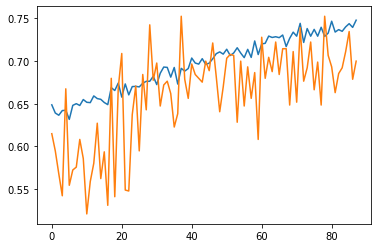

In [43]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_history.png")

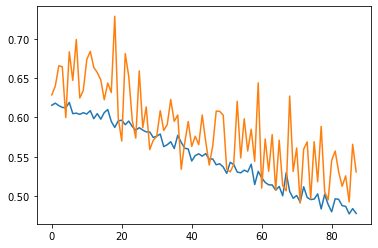

In [44]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_loss.png")

In [45]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(testData),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(testData)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

149/149 [==============================] - 1s 5ms/step
[0 1]


0.4682124158563949


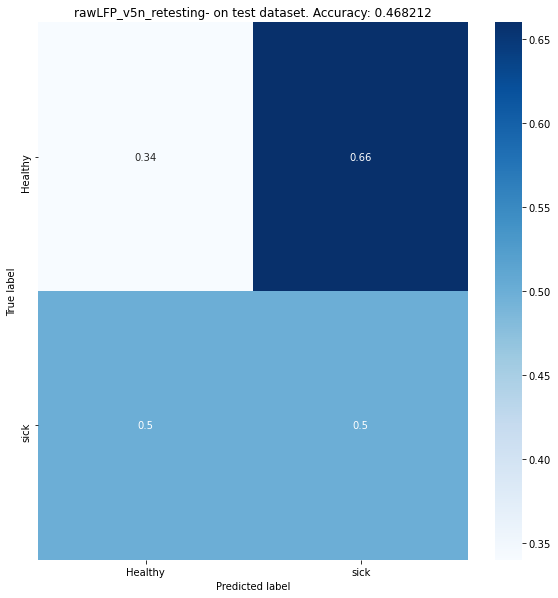

In [46]:

classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Test.png")
print(np.sum(y==pred)/len(y))

In [47]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(validate),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(validate)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

100/100 [==============================] - 1s 6ms/step
[0 1]


0.72


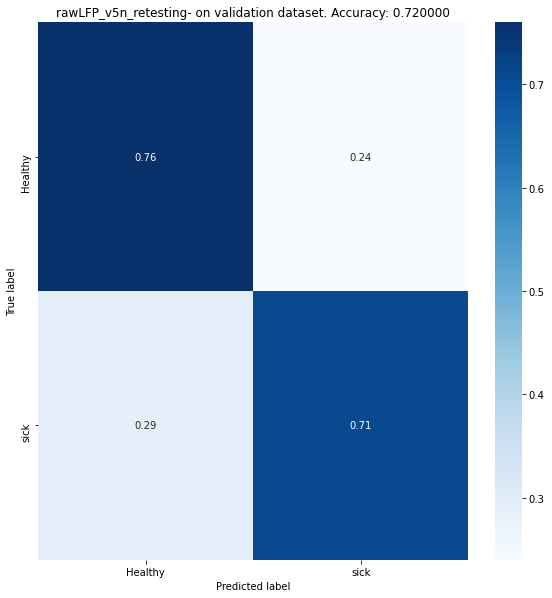

In [49]:
classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on validation dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_val.png")
print(np.sum(y==pred)/len(y))

In [50]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(trainData),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(trainData)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

899/899 [==============================] - 5s 5ms/step
[0 1]


0.702819688350235


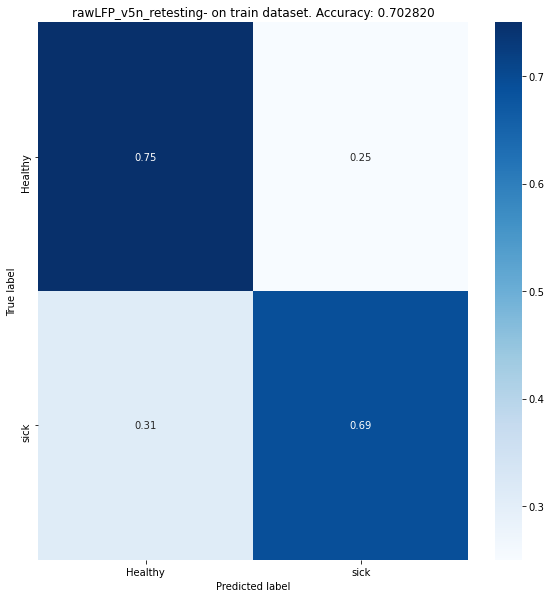

In [51]:
classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")
print(np.sum(y==pred)/len(y))

In [19]:
def dataSplits(i):
    df = pd.read_csv('availableData2.csv')  
    # try 30s with 20s overlab
    dtL = 0.0032768
    segN = int(np.ceil(15/dtL))
    overlap = int(np.ceil(3/dtL))
    dataSamples = prepData(segN,overlap,df)

    df = prepData(segN,overlap,df)
    testData = df[df.Mouse.isin(mTest)]
    trainData = df[df.Mouse.isin(mTrain)]
    return trainData,testData
                   

In [20]:
def plotHistory(history,modelName,dfName,i):
    fig, ax = plt.subplots(2,1, figsize=(8, 8))
    ax[0].plot(history.history['accuracy'],label='train')
    ax[0].plot(history.history['val_accuracy'],label='validation')
    ax[0].set_title('Accuracy')
    ax[1].plot(history.history['loss'],label='train')
    ax[1].plot(history.history['val_loss'],label='validation')
    ax[1].set_title('Loss')
    fig.savefig("E:\\NN\\"+modelName+"_history_"+dfName+"_"+i[0]+"_"+i[1]+".svg")
    fig.clf()
    plt.close(fig)

In [21]:
def plotConfusionMatrix(y,pred,modelName, dfName):
    con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)
    fig, ax = plt.subplots(1,1, figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,ax=ax)
    #fig.tight_layout()
    ax.set_title((modelName +"- on "+dfName+" dataset. Accuracy: {acc:f}").format(acc=np.sum(y==pred)/len(y)) )
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.savefig("E:\\NN\\"+modelName+"_confusionOn_"+dfName+".svg")
    fig.clf()
    plt.close(fig)

In [22]:
def plotROC(fpr,tpr,sname):
    fig, ax = plt.subplots()
    mean_fpr = np.arange(0,100)/100
    mean_tpr = []
    aucs = []
    for i in range(len(fpr)):
        ax.plot(fpr[i],tpr[i],alpha=0.3) #label="ROC fold {}".format(i),
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        mean_tpr.append(interp_tpr)
        aucs.append(auc(fpr[i], tpr[i]))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    
    mean_auc = auc(mean_fpr, np.mean(mean_tpr,axis=0))
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,np.mean(mean_tpr,axis=0),color='b',label = r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc))
    ax.set_xlabel("TPR")
    ax.set_ylabel("FPR")
    ax.legend(loc="lower right")
    fig.savefig("E:\\NN\\"+sname+".svg")
    fig.clf()
    plt.close(fig)

In [122]:
from itertools import combinations
dt = 0.05
dfrigor = pd.DataFrame(columns=['itr'])

modelName = 'retesting_v5n_allSplits'
batchSize = 64
sampleSize = batchSize//2
classes=['Healthy','Acute']

# os.mkdir('E:\\NN\\confusionMatrices\\retestingLFPv5n')
folder = 'confusionMatrices\\retestingLFPv5n\\' 
comb_List = []
comb = combinations(miceList, 2)
for i in tqdm(comb):
    comb_List.append(i)

fpr = []
tpr = []

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

for i in tqdm(comb_List[1:]):
    
    trainData,testData = dataSplits(i) 
            
    for l in tqdm(range(2)): # 5-fold cross validation
        results = {'Test':{},'Train':{},'Val':{}}
        
        valData = trainData.iloc[(len(trainData)//5)*l:(len(trainData)//5)*(l+1)]
        trainData = trainData.drop(valData.index)

        stepTrain=len(trainData)//batchSize
        stepValidate=len(valData)//batchSize

        model =  tf.keras.models.load_model('E:\\rawLFP_v5n_tunning_binary')
        model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
        # model.load_weights('E:\\'+modelName+'_bestWeights.h5')
        
        history = model.fit(loadTrain(trainData,sampleSize),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate,sampleSize),
                    validation_steps=stepValidate,
                    epochs=1200,callbacks=[early_stopping])#,

        
        plotHistory(history,folder+modelName,str(l),i)
        #  test and save scores
        
        y = []
        for ind,(dataP,label) in enumerate(loadTest(testData)):
            y = y+list(np.argmax(label,axis=1))

        pred = model.predict_generator(loadTest(testData),verbose=1)

        fpr_t , tpr_t , thresholds = roc_curve ( y , pred[:,1])
        fpr.append(fpr_t)
        tpr.append(tpr_t)

        pred = np.argmax(pred, axis = 1)
        plotConfusionMatrix(y,pred,folder+str(l)+modelName+"_"+str(i[0])+"_"+str(i[1]), 'test')
        y = np.array(y)
        results['Test']['Acc'] = (np.sum(y==pred)/len(y))
        results['Test']['Sen'] = (np.sum(y*pred)/sum(y))
        results['Test']['Spe'] = np.sum(1*(y == pred)*(y==0))/sum(y==0)
        results['Test']['AUC'] = auc(fpr_t, tpr_t)

        y = []
        for ind,(dataP,label) in enumerate(loadTest(trainData)):
            y = y+list(np.argmax(label,axis=1))

        pred = model.predict_generator(loadTest(trainData),verbose=1)
        pred = np.argmax(pred, axis = 1)

        plotConfusionMatrix(y,pred,folder+str(l)+modelName+"_"+str(i[0])+"_"+str(i[1]), 'train')
        y = np.array(y)
        results['Train']['Acc'] = (np.sum(y==pred)/len(y))
        results['Train']['Sen'] = (np.sum(y*pred)/sum(y))
        results['Train']['Spe'] = np.sum(1*(y == pred)*(y==0))/sum(y==0)

        y = []
        for ind,(dataP,label) in enumerate(loadTest(valData)):
            y = y+list(np.argmax(label,axis=1))

        pred = model.predict_generator(loadTest(valData),verbose=1)
        pred = np.argmax(pred, axis = 1)

        plotConfusionMatrix(y,pred,folder+str(l)+modelName+"_"+str(i[0])+"_"+str(i[1]), 'val')
        y = np.array(y)
        results['Val']['Acc'] = (np.sum(y==pred)/len(y))
        results['Val']['Sen'] = (np.sum(y*pred)/sum(y))
        results['Val']['Spe'] = np.sum(1*(y == pred)*(y==0))/sum(y==0)

        del model


        for spl in ['Test','Train','Val']:
            dfrow = pd.DataFrame(results[spl],index=[0])
            dfrow['split'] = spl
            dfrow['itr'] = l
            dfrow['i'] = str(i)
            dfrigor = pd.concat([dfrigor,dfrow])
            
plotROC(fpr,tpr,"section3_AUC_LFP_retrain")

dfrigor.to_csv("E:\\NN\\results_LFP_retrain.csv")

91it [00:00, ?it/s]
  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Epoch 1/1200
112/112 [==============================] - 5s 43ms/step - loss: 0.6325 - accuracy: 0.6278 - val_loss: 0.6271 - val_accuracy: 0.6228
Epoch 2/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6255 - accuracy: 0.6356 - val_loss: 0.6153 - val_accuracy: 0.6814
Epoch 3/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6288 - accuracy: 0.6286 - val_loss: 0.6678 - val_accuracy: 0.5887
Epoch 4/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6292 - accuracy: 0.6334 - val_loss: 0.6170 - val_accuracy: 0.6535
Epoch 5/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.6215 - accuracy: 0.6395 - val_loss: 0.6414 - val_accuracy: 0.6016
Epoch 6/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.6211 - accuracy: 0.6462 - val_loss: 0.6772 - val_accuracy: 0.5670
Epoch 7/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.6188 - accuracy: 0.6483 - val_loss: 0.6229 - val_ac

112/112 [==============================] - 5s 42ms/step - loss: 0.4768 - accuracy: 0.7559 - val_loss: 0.6258 - val_accuracy: 0.6663
Epoch 113/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4663 - accuracy: 0.7529 - val_loss: 0.6802 - val_accuracy: 0.6568
Epoch 114/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.4544 - accuracy: 0.7686 - val_loss: 0.6837 - val_accuracy: 0.6881
Epoch 115/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4597 - accuracy: 0.7580 - val_loss: 0.6223 - val_accuracy: 0.6769
Epoch 116/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4691 - accuracy: 0.7577 - val_loss: 0.6029 - val_accuracy: 0.6936
Epoch 117/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4571 - accuracy: 0.7695 - val_loss: 0.6437 - val_accuracy: 0.6629
Epoch 118/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4447 - accuracy: 0.7667 - val_loss: 0.6865 - val_acc

Epoch 223/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.2253 - accuracy: 0.8979 - val_loss: 1.1441 - val_accuracy: 0.7695
Epoch 224/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2332 - accuracy: 0.8920 - val_loss: 1.0073 - val_accuracy: 0.7651
Epoch 225/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2169 - accuracy: 0.8976 - val_loss: 1.2038 - val_accuracy: 0.7433
Epoch 226/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.2227 - accuracy: 0.8933 - val_loss: 1.0850 - val_accuracy: 0.7372
Epoch 227/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2246 - accuracy: 0.8892 - val_loss: 1.0819 - val_accuracy: 0.7706
Epoch 228/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2385 - accuracy: 0.8933 - val_loss: 0.9367 - val_accuracy: 0.7863
Epoch 229/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2123 - accuracy: 0.9021 - val_loss: 0

Epoch 334/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1272 - accuracy: 0.9461 - val_loss: 1.1178 - val_accuracy: 0.8136
Epoch 335/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1429 - accuracy: 0.9429 - val_loss: 1.3697 - val_accuracy: 0.7985
Epoch 336/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1236 - accuracy: 0.9481 - val_loss: 1.4602 - val_accuracy: 0.7427
Epoch 337/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1533 - accuracy: 0.9330 - val_loss: 1.5490 - val_accuracy: 0.7662
Epoch 338/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1190 - accuracy: 0.9475 - val_loss: 1.3535 - val_accuracy: 0.7902
Epoch 339/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1181 - accuracy: 0.9477 - val_loss: 1.5756 - val_accuracy: 0.7706
Epoch 340/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1306 - accuracy: 0.9422 - val_loss: 1

112/112 [==============================] - 5s 42ms/step - loss: 0.0879 - accuracy: 0.9658 - val_loss: 1.8901 - val_accuracy: 0.7935
Epoch 445/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1028 - accuracy: 0.9619 - val_loss: 1.7904 - val_accuracy: 0.7768
Epoch 446/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0971 - accuracy: 0.9597 - val_loss: 2.2992 - val_accuracy: 0.7835
Epoch 447/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0810 - accuracy: 0.9674 - val_loss: 1.7785 - val_accuracy: 0.7980
Epoch 448/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.0754 - accuracy: 0.9690 - val_loss: 2.0353 - val_accuracy: 0.7985
Epoch 449/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0854 - accuracy: 0.9662 - val_loss: 1.6861 - val_accuracy: 0.7980
Epoch 450/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0914 - accuracy: 0.9646 - val_loss: 2.1423 - val_acc

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


149/149 [==============================] - 1s 5ms/step
     23/Unknown - 0s 5ms/step

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


200/200 [==============================] - 1s 5ms/step



 50%|█████████████████████████████████████████                                         | 1/2 [38:14<38:14, 2294.84s/it]

Epoch 1/1200
89/89 [==============================] - 4s 43ms/step - loss: 0.6354 - accuracy: 0.6199 - val_loss: 0.6455 - val_accuracy: 0.5902
Epoch 2/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6166 - accuracy: 0.6294 - val_loss: 0.6473 - val_accuracy: 0.6072
Epoch 3/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.6170 - accuracy: 0.6299 - val_loss: 0.6564 - val_accuracy: 0.5618
Epoch 4/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.6108 - accuracy: 0.6313 - val_loss: 0.6381 - val_accuracy: 0.6278
Epoch 5/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6088 - accuracy: 0.6313 - val_loss: 0.6568 - val_accuracy: 0.5675
Epoch 6/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.6115 - accuracy: 0.6292 - val_loss: 0.6633 - val_accuracy: 0.5469
Epoch 7/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.6080 - accuracy: 0.6382 - val_loss: 0.6391 - val_accuracy: 0.5987

Epoch 58/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5373 - accuracy: 0.6910 - val_loss: 0.6651 - val_accuracy: 0.6499
Epoch 59/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5337 - accuracy: 0.6873 - val_loss: 0.8017 - val_accuracy: 0.6300
Epoch 60/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5262 - accuracy: 0.7072 - val_loss: 0.6939 - val_accuracy: 0.6570
Epoch 61/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.5409 - accuracy: 0.6929 - val_loss: 0.8037 - val_accuracy: 0.5852
Epoch 62/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5181 - accuracy: 0.7089 - val_loss: 0.7240 - val_accuracy: 0.6456
Epoch 63/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.5226 - accuracy: 0.7047 - val_loss: 0.8018 - val_accuracy: 0.6293
Epoch 64/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5393 - accuracy: 0.6887 - val_loss: 0.7117 - val_accuracy:

Epoch 115/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4210 - accuracy: 0.7719 - val_loss: 0.9548 - val_accuracy: 0.6385
Epoch 116/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4403 - accuracy: 0.7691 - val_loss: 0.9728 - val_accuracy: 0.6392
Epoch 117/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4126 - accuracy: 0.7811 - val_loss: 0.8455 - val_accuracy: 0.6534
Epoch 118/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4149 - accuracy: 0.7784 - val_loss: 0.9294 - val_accuracy: 0.6229
Epoch 119/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4184 - accuracy: 0.7814 - val_loss: 1.0027 - val_accuracy: 0.6200
Epoch 120/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4189 - accuracy: 0.7765 - val_loss: 1.1232 - val_accuracy: 0.6548
Epoch 121/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4141 - accuracy: 0.7877 - val_loss: 0.8376 - val_ac

89/89 [==============================] - 4s 42ms/step - loss: 0.2205 - accuracy: 0.8978 - val_loss: 2.1218 - val_accuracy: 0.6854
Epoch 227/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2128 - accuracy: 0.9012 - val_loss: 2.2216 - val_accuracy: 0.6896
Epoch 228/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2286 - accuracy: 0.8899 - val_loss: 1.9658 - val_accuracy: 0.6839
Epoch 229/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.2178 - accuracy: 0.9003 - val_loss: 1.6937 - val_accuracy: 0.6918
Epoch 230/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2209 - accuracy: 0.8957 - val_loss: 1.9105 - val_accuracy: 0.6996
Epoch 231/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2236 - accuracy: 0.8897 - val_loss: 1.8211 - val_accuracy: 0.7138
Epoch 232/1200
89/89 [==============================] - 4s 43ms/step - loss: 0.2570 - accuracy: 0.8783 - val_loss: 2.1818 - val_accuracy: 0.6889


89/89 [==============================] - 4s 41ms/step - loss: 0.1258 - accuracy: 0.9494 - val_loss: 3.3174 - val_accuracy: 0.7195
Epoch 339/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.1185 - accuracy: 0.9519 - val_loss: 2.5987 - val_accuracy: 0.7308: 0.1191 - accuracy: 
Epoch 340/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.1431 - accuracy: 0.9363 - val_loss: 2.7989 - val_accuracy: 0.7081
Epoch 341/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.1050 - accuracy: 0.9545 - val_loss: 2.8350 - val_accuracy: 0.6953
Epoch 342/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.1085 - accuracy: 0.9545 - val_loss: 2.9657 - val_accuracy: 0.7131
Epoch 343/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.1144 - accuracy: 0.9498 - val_loss: 2.8412 - val_accuracy: 0.7237
Epoch 344/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.0915 - accuracy: 0.9617 - val_loss: 3.3821 - 

89/89 [==============================] - 4s 42ms/step - loss: 0.0869 - accuracy: 0.9672 - val_loss: 3.7390 - val_accuracy: 0.7152
Epoch 451/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.0696 - accuracy: 0.9735 - val_loss: 3.9690 - val_accuracy: 0.6918
Epoch 452/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.1207 - accuracy: 0.9556 - val_loss: 2.9196 - val_accuracy: 0.7330
Epoch 453/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.0604 - accuracy: 0.9737 - val_loss: 2.9165 - val_accuracy: 0.7259
Epoch 454/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.0663 - accuracy: 0.9705 - val_loss: 3.1512 - val_accuracy: 0.7408
Epoch 455/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.0743 - accuracy: 0.9714 - val_loss: 3.5590 - val_accuracy: 0.7379
Epoch 456/1200
89/89 [==============================] - 4s 40ms/step - loss: 0.0638 - accuracy: 0.9763 - val_loss: 4.0947 - val_accuracy: 0.7116


89/89 [==============================] - 4s 42ms/step - loss: 0.0482 - accuracy: 0.9819 - val_loss: 4.3829 - val_accuracy: 0.7102
Epoch 563/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.0423 - accuracy: 0.9828 - val_loss: 5.5244 - val_accuracy: 0.7131 0s - loss: 0.0405 - 
Epoch 564/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.0464 - accuracy: 0.9835 - val_loss: 3.9337 - val_accuracy: 0.7315
Restoring model weights from the end of the best epoch.
Epoch 00564: early stopping
149/149 [==============================] - 1s 5ms/step
     23/Unknown - 0s 5ms/step

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


160/160 [==============================] - 1s 5ms/step



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Epoch 1/1200
112/112 [==============================] - 5s 43ms/step - loss: 0.6341 - accuracy: 0.6221 - val_loss: 0.6460 - val_accuracy: 0.6133
Epoch 2/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6340 - accuracy: 0.6286 - val_loss: 0.6178 - val_accuracy: 0.6518
Epoch 3/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6334 - accuracy: 0.6223 - val_loss: 0.6429 - val_accuracy: 0.6010
Epoch 4/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6261 - accuracy: 0.6366 - val_loss: 0.6369 - val_accuracy: 0.6417
Epoch 5/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6295 - accuracy: 0.6345 - val_loss: 0.6393 - val_accuracy: 0.6016
Epoch 6/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6209 - accuracy: 0.6508 - val_loss: 0.6390 - val_accuracy: 0.5831
Epoch 7/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6307 - accuracy: 0.6318 - val_loss: 0.6246 - val_ac

Epoch 113/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.4520 - accuracy: 0.7613 - val_loss: 0.6116 - val_accuracy: 0.6724
Epoch 114/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4730 - accuracy: 0.7465 - val_loss: 0.6155 - val_accuracy: 0.6769
Epoch 115/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.4616 - accuracy: 0.7591 - val_loss: 0.6509 - val_accuracy: 0.6959
Epoch 116/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4491 - accuracy: 0.7580 - val_loss: 0.7185 - val_accuracy: 0.6802
Epoch 117/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4342 - accuracy: 0.7725 - val_loss: 0.7231 - val_accuracy: 0.6747
Epoch 118/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4353 - accuracy: 0.7762 - val_loss: 0.6843 - val_accuracy: 0.6350
Epoch 119/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4280 - accuracy: 0.7789 - val_loss: 0

112/112 [==============================] - 5s 41ms/step - loss: 0.2264 - accuracy: 0.8954 - val_loss: 0.9966 - val_accuracy: 0.7478
Epoch 224/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2450 - accuracy: 0.8913 - val_loss: 0.9890 - val_accuracy: 0.7366
Epoch 225/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2274 - accuracy: 0.9012 - val_loss: 1.0424 - val_accuracy: 0.7489: 0.2267 - accuracy: 
Epoch 226/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2321 - accuracy: 0.8979 - val_loss: 0.9820 - val_accuracy: 0.7299
Epoch 227/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2305 - accuracy: 0.8969 - val_loss: 1.0729 - val_accuracy: 0.7656
Epoch 228/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2256 - accuracy: 0.9003 - val_loss: 1.0747 - val_accuracy: 0.7679
Epoch 229/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2452 - accuracy: 0.8901 - val_l

Epoch 334/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1321 - accuracy: 0.9474 - val_loss: 1.0412 - val_accuracy: 0.7952
Epoch 335/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1135 - accuracy: 0.9519 - val_loss: 1.2810 - val_accuracy: 0.7991
Epoch 336/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1199 - accuracy: 0.9499 - val_loss: 1.0216 - val_accuracy: 0.8170
Epoch 337/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1197 - accuracy: 0.9494 - val_loss: 0.8423 - val_accuracy: 0.8186
Epoch 338/1200
112/112 [==============================] - 4s 40ms/step - loss: 0.2362 - accuracy: 0.9138 - val_loss: 0.7612 - val_accuracy: 0.7946
Epoch 339/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1296 - accuracy: 0.9505 - val_loss: 1.2455 - val_accuracy: 0.7974
Epoch 340/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1107 - accuracy: 0.9519 - val_loss: 1

Epoch 390/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1026 - accuracy: 0.9583 - val_loss: 1.4220 - val_accuracy: 0.8164
Epoch 391/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0800 - accuracy: 0.9660 - val_loss: 1.3612 - val_accuracy: 0.8092
Epoch 392/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0977 - accuracy: 0.9604 - val_loss: 1.5398 - val_accuracy: 0.8147
Epoch 393/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0964 - accuracy: 0.9614 - val_loss: 1.3340 - val_accuracy: 0.8253
Epoch 394/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0946 - accuracy: 0.9612 - val_loss: 1.0771 - val_accuracy: 0.8203
Epoch 395/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1012 - accuracy: 0.9633 - val_loss: 1.3571 - val_accuracy: 0.8064
Epoch 396/1200
112/112 [==============================] - 4s 40ms/step - loss: 0.0941 - accuracy: 0.9634 - val_loss: 1

Epoch 446/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0542 - accuracy: 0.9803 - val_loss: 1.6553 - val_accuracy: 0.8147
Epoch 447/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0874 - accuracy: 0.9694 - val_loss: 1.6110 - val_accuracy: 0.7919
Epoch 448/1200
112/112 [==============================] - 5s 40ms/step - loss: 0.0710 - accuracy: 0.9739 - val_loss: 1.6099 - val_accuracy: 0.8008
Epoch 449/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0624 - accuracy: 0.9749 - val_loss: 1.6753 - val_accuracy: 0.8142
Epoch 450/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0637 - accuracy: 0.9764 - val_loss: 1.8584 - val_accuracy: 0.7840
Epoch 451/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0629 - accuracy: 0.9775 - val_loss: 1.7685 - val_accuracy: 0.8142
Epoch 452/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0591 - accuracy: 0.9764 - val_loss: 2

Epoch 502/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0791 - accuracy: 0.9759 - val_loss: 1.7791 - val_accuracy: 0.8147
Epoch 503/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0646 - accuracy: 0.9741 - val_loss: 1.8134 - val_accuracy: 0.8025
Epoch 504/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0673 - accuracy: 0.9777 - val_loss: 1.9460 - val_accuracy: 0.8069
Epoch 505/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0516 - accuracy: 0.9794 - val_loss: 1.2947 - val_accuracy: 0.8265
Epoch 506/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0548 - accuracy: 0.9787 - val_loss: 2.4042 - val_accuracy: 0.8147
Epoch 507/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0429 - accuracy: 0.9852 - val_loss: 1.9794 - val_accuracy: 0.8242
Epoch 508/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0484 - accuracy: 0.9819 - val_loss: 1

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


200/200 [==============================] - 1s 5ms/step



 50%|█████████████████████████████████████████                                         | 1/2 [38:54<38:54, 2334.52s/it]

Epoch 1/1200
89/89 [==============================] - 4s 43ms/step - loss: 0.6311 - accuracy: 0.6185 - val_loss: 0.6172 - val_accuracy: 0.6442
Epoch 2/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6183 - accuracy: 0.6371 - val_loss: 0.6248 - val_accuracy: 0.6435
Epoch 3/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6175 - accuracy: 0.6199 - val_loss: 0.6492 - val_accuracy: 0.5732
Epoch 4/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6132 - accuracy: 0.6334 - val_loss: 0.6492 - val_accuracy: 0.6136
Epoch 5/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6164 - accuracy: 0.6246 - val_loss: 0.6558 - val_accuracy: 0.5831
Epoch 6/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6079 - accuracy: 0.6399 - val_loss: 0.6228 - val_accuracy: 0.6207
Epoch 7/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6045 - accuracy: 0.6369 - val_loss: 0.6594 - val_accuracy: 0.5959

Epoch 58/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5250 - accuracy: 0.7070 - val_loss: 0.8634 - val_accuracy: 0.5987
Epoch 59/1200
89/89 [==============================] - 4s 40ms/step - loss: 0.5224 - accuracy: 0.7029 - val_loss: 0.8104 - val_accuracy: 0.6200
Epoch 60/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5472 - accuracy: 0.6933 - val_loss: 0.7598 - val_accuracy: 0.5895
Epoch 61/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5161 - accuracy: 0.7138 - val_loss: 0.6668 - val_accuracy: 0.6570
Epoch 62/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5304 - accuracy: 0.6921 - val_loss: 0.6711 - val_accuracy: 0.6911
Epoch 63/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5397 - accuracy: 0.6914 - val_loss: 0.7993 - val_accuracy: 0.6200
Epoch 64/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5216 - accuracy: 0.7068 - val_loss: 0.8519 - val_accuracy:

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


160/160 [==============================] - 1s 5ms/step



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Epoch 1/1200
112/112 [==============================] - 6s 44ms/step - loss: 0.6329 - accuracy: 0.6289 - val_loss: 0.6924 - val_accuracy: 0.5285
Epoch 2/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.6327 - accuracy: 0.6302 - val_loss: 0.6864 - val_accuracy: 0.5753
Epoch 3/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6288 - accuracy: 0.6288 - val_loss: 0.6504 - val_accuracy: 0.5938
Epoch 4/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6285 - accuracy: 0.6324 - val_loss: 0.6340 - val_accuracy: 0.5977
Epoch 5/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.6223 - accuracy: 0.6436 - val_loss: 0.6203 - val_accuracy: 0.6462
Epoch 6/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.6272 - accuracy: 0.6342 - val_loss: 0.6528 - val_accuracy: 0.6177
Epoch 7/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.6271 - accuracy: 0.6387 - val_loss: 0.6317 - val_ac

112/112 [==============================] - 5s 41ms/step - loss: 0.4297 - accuracy: 0.7673 - val_loss: 0.7091 - val_accuracy: 0.6842
Epoch 113/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4323 - accuracy: 0.7659 - val_loss: 0.6423 - val_accuracy: 0.7003
Epoch 114/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4498 - accuracy: 0.7593 - val_loss: 0.7010 - val_accuracy: 0.6529
Epoch 115/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4341 - accuracy: 0.7670 - val_loss: 0.6376 - val_accuracy: 0.7042
Epoch 116/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4344 - accuracy: 0.7753 - val_loss: 0.6539 - val_accuracy: 0.6741
Epoch 117/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.4364 - accuracy: 0.7775 - val_loss: 0.7449 - val_accuracy: 0.6724
Epoch 118/1200
112/112 [==============================] - 4s 40ms/step - loss: 0.4287 - accuracy: 0.7683 - val_loss: 0.6974 - val_acc

Epoch 223/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2350 - accuracy: 0.8920 - val_loss: 0.9043 - val_accuracy: 0.7969
Epoch 224/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2184 - accuracy: 0.9035 - val_loss: 0.8146 - val_accuracy: 0.7690
Epoch 225/1200
112/112 [==============================] - 4s 40ms/step - loss: 0.2211 - accuracy: 0.8997 - val_loss: 0.8961 - val_accuracy: 0.7846
Epoch 226/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2155 - accuracy: 0.8983 - val_loss: 0.9591 - val_accuracy: 0.7985
Epoch 227/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2092 - accuracy: 0.9012 - val_loss: 1.3471 - val_accuracy: 0.7612
Epoch 228/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2222 - accuracy: 0.8940 - val_loss: 0.8251 - val_accuracy: 0.8008
Epoch 229/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.2192 - accuracy: 0.8940 - val_loss: 0

Epoch 279/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1723 - accuracy: 0.9294 - val_loss: 1.1291 - val_accuracy: 0.7919
Epoch 280/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1480 - accuracy: 0.9344 - val_loss: 1.1768 - val_accuracy: 0.7779
Epoch 281/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1586 - accuracy: 0.9316 - val_loss: 1.4815 - val_accuracy: 0.7801
Epoch 282/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1486 - accuracy: 0.9335 - val_loss: 1.2395 - val_accuracy: 0.8019
Epoch 283/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1503 - accuracy: 0.9339 - val_loss: 1.0715 - val_accuracy: 0.8030
Epoch 284/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1415 - accuracy: 0.9403 - val_loss: 1.3564 - val_accuracy: 0.7952
Epoch 285/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.1420 - accuracy: 0.9351 - val_loss: 1

Epoch 390/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.0957 - accuracy: 0.9625 - val_loss: 1.7952 - val_accuracy: 0.8064
Epoch 391/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1254 - accuracy: 0.9544 - val_loss: 1.8823 - val_accuracy: 0.7935
Epoch 392/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0941 - accuracy: 0.9622 - val_loss: 1.3128 - val_accuracy: 0.7941
Epoch 393/1200
112/112 [==============================] - 5s 41ms/step - loss: 0.0843 - accuracy: 0.9634 - val_loss: 1.5637 - val_accuracy: 0.8013
Epoch 394/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.1045 - accuracy: 0.9607 - val_loss: 1.4595 - val_accuracy: 0.7874
Epoch 395/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.0859 - accuracy: 0.9648 - val_loss: 1.5385 - val_accuracy: 0.8136
Epoch 396/1200
112/112 [==============================] - 5s 42ms/step - loss: 0.0933 - accuracy: 0.9653 - val_loss: 1

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


200/200 [==============================] - 1s 5ms/step



 50%|█████████████████████████████████████████                                         | 1/2 [33:24<33:24, 2004.30s/it]

Epoch 1/1200
89/89 [==============================] - 5s 44ms/step - loss: 0.6229 - accuracy: 0.6306 - val_loss: 0.6905 - val_accuracy: 0.5518
Epoch 2/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.6211 - accuracy: 0.6220 - val_loss: 0.6352 - val_accuracy: 0.6278
Epoch 3/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6258 - accuracy: 0.6166 - val_loss: 0.6403 - val_accuracy: 0.6122
Epoch 4/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6118 - accuracy: 0.6419 - val_loss: 0.6457 - val_accuracy: 0.5881
Epoch 5/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6132 - accuracy: 0.6408 - val_loss: 0.6579 - val_accuracy: 0.6222
Epoch 6/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6107 - accuracy: 0.6373 - val_loss: 0.6439 - val_accuracy: 0.6250
Epoch 7/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.6139 - accuracy: 0.6352 - val_loss: 0.6563 - val_accuracy: 0.6413

Epoch 58/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5329 - accuracy: 0.6963 - val_loss: 0.8689 - val_accuracy: 0.5689
Epoch 59/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5408 - accuracy: 0.7012 - val_loss: 0.8133 - val_accuracy: 0.6108
Epoch 60/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5362 - accuracy: 0.6984 - val_loss: 0.7854 - val_accuracy: 0.5952
Epoch 61/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5588 - accuracy: 0.6761 - val_loss: 0.7449 - val_accuracy: 0.5312
Epoch 62/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5283 - accuracy: 0.7008 - val_loss: 0.8885 - val_accuracy: 0.5703
Epoch 63/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.5556 - accuracy: 0.6801 - val_loss: 0.6774 - val_accuracy: 0.6385
Epoch 64/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.5250 - accuracy: 0.7070 - val_loss: 0.7173 - val_accuracy:

Epoch 115/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4452 - accuracy: 0.7662 - val_loss: 0.7794 - val_accuracy: 0.6570
Epoch 116/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4755 - accuracy: 0.7400 - val_loss: 0.8387 - val_accuracy: 0.6584
Epoch 117/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4333 - accuracy: 0.7646 - val_loss: 0.9805 - val_accuracy: 0.6378
Epoch 118/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4678 - accuracy: 0.7432 - val_loss: 0.9217 - val_accuracy: 0.5092
Epoch 119/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.4376 - accuracy: 0.7588 - val_loss: 0.8825 - val_accuracy: 0.6456
Epoch 120/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4342 - accuracy: 0.7711 - val_loss: 1.0286 - val_accuracy: 0.6165
Epoch 121/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.4372 - accuracy: 0.7640 - val_loss: 0.7547 - val_ac

89/89 [==============================] - 4s 41ms/step - loss: 0.2332 - accuracy: 0.8885 - val_loss: 1.3677 - val_accuracy: 0.6861
Epoch 228/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2309 - accuracy: 0.8897 - val_loss: 1.8381 - val_accuracy: 0.6783
Epoch 229/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.2661 - accuracy: 0.8748 - val_loss: 1.6063 - val_accuracy: 0.6918
Epoch 230/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2203 - accuracy: 0.8982 - val_loss: 1.9281 - val_accuracy: 0.6925
Epoch 231/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2646 - accuracy: 0.8666 - val_loss: 1.3437 - val_accuracy: 0.7053
Epoch 232/1200
89/89 [==============================] - 4s 42ms/step - loss: 0.2254 - accuracy: 0.8933 - val_loss: 1.7508 - val_accuracy: 0.6754
Epoch 233/1200
89/89 [==============================] - 4s 41ms/step - loss: 0.2236 - accuracy: 0.8927 - val_loss: 1.6655 - val_accuracy: 0.7188


  2%|█▋                                                                         | 2/90 [2:52:46<126:41:46, 5183.03s/it]


KeyboardInterrupt: 

In [123]:
plotROC(fpr,tpr,"section3_AUC_LFP_retrain")

dfrigor.to_csv("E:\\NN\\results_LFP_retrain.csv")

before that looking at test dataset/split - do a 10 fold cross validation on all data....

In [53]:
from itertools import combinations
dt = 0.05
# dfrigor = pd.read_csv("E:\\NN\\results_LFP_retrain_crossVal.csv")
dfrigor = pd.DataFrame(columns=['itr'])
modelName = 'retesting_v5n_allSplits_30'
batchSize = 64
sampleSize = batchSize//2
classes=['Healthy','Acute']

os.mkdir('E:\\NN\\confusionMatrices\\retestingLFPv5n_crossVal_5')
folder = 'confusionMatrices\\retestingLFPv5n_crossVal_5\\' 
# comb_List = []
# comb = combinations(miceList, 2)
# for i in comb:
#     comb_List.append(i)

fpr = []
tpr = []

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=75,
    mode='max',
    restore_best_weights=True)

# df = pd.read_csv('availableData2.csv')  
# try 30s with 20s overlab
dtL = 0.0032768
segN = int(np.ceil(5/dtL))
overlap = int(np.ceil(1/dtL))

# df = prepData(segN,overlap,df)
df = df.sort_values('start')

for l in tqdm(range(0,10)): # 10-fold cross validation
    results = {'Test':{},'Train':{},'Val':{}}
    
    trainData = df.copy()
    valData = trainData.iloc[(len(trainData)//10)*l:(len(trainData)//10)*(l+1)]
    trainData = trainData.drop(valData.index)

    stepTrain=len(trainData)//batchSize
    stepValidate=len(valData)//batchSize

#     model =  get_model(segN)
    model = get_model(segN)# tf.keras.models.load_model('E:\\rawLFP_v5n_tunning_binary')
    model.compile(optimizer='sgd',
          loss=tf.keras.losses.CategoricalCrossentropy(),
          metrics=['accuracy'])
    # model.load_weights('E:\\'+modelName+'_bestWeights.h5')

    history = model.fit(loadTrain(trainData,sampleSize),
                steps_per_epoch=stepTrain,
                validation_data=loadTrain(valData,sampleSize),
                validation_steps=stepValidate,
                epochs=1200,callbacks=[early_stopping])#,


    plotHistory(history,folder+modelName,str(l),'bla')
    #  test and save scores

    y = []
    for ind,(dataP,label) in enumerate(loadTest(trainData)):
        y = y+list(np.argmax(label,axis=1))

    pred = model.predict_generator(loadTest(trainData),verbose=1)
    pred = np.argmax(pred, axis = 1)

    plotConfusionMatrix(y,pred,folder+str(l)+modelName, 'train')
    y = np.array(y)
    results['Train']['Acc'] = (np.sum(y==pred)/len(y))
    results['Train']['Sen'] = (np.sum(y*pred)/sum(y))
    results['Train']['Spe'] = np.sum(1*(y == pred)*(y==0))/sum(y==0)

    y = []
    for ind,(dataP,label) in enumerate(loadTest(valData)):
        y = y+list(np.argmax(label,axis=1))

    pred = model.predict_generator(loadTest(valData),verbose=1)
    fpr_t , tpr_t , thresholds = roc_curve ( y , pred[:,1])
    fpr.append(fpr_t)
    tpr.append(tpr_t)
    pred = np.argmax(pred, axis = 1)

    plotConfusionMatrix(y,pred,folder+str(l)+modelName, 'val')
    y = np.array(y)
    results['Val']['Acc'] = (np.sum(y==pred)/len(y))
    results['Val']['Sen'] = (np.sum(y*pred)/sum(y))
    results['Val']['Spe'] = np.sum(1*(y == pred)*(y==0))/sum(y==0)

    del model


    for spl in ['Test','Train','Val']:
        dfrow = pd.DataFrame(results[spl],index=[0])
        dfrow['split'] = spl
        dfrow['itr'] = l
#         dfrow['i'] = str(i)
        dfrigor = pd.concat([dfrigor,dfrow])

plotROC(fpr,tpr,"section3_AUC_LFP_retrain_crossVal_5")

dfrigor.to_csv("E:\\NN\\results_LFP_retrain_crossVal_5.csv")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/1200
438/438 [==============================] - 16s 34ms/step - loss: 0.6925 - accuracy: 0.5122 - val_loss: 0.6927 - val_accuracy: 0.4909
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6902 - accuracy: 0.5319 - val_loss: 0.6930 - val_accuracy: 0.4967
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6853 - accuracy: 0.5539 - val_loss: 0.6955 - val_accuracy: 0.5072
Epoch 4/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6792 - accuracy: 0.5627 - val_loss: 0.6920 - val_accuracy: 0.5107- accuracy: 0. - ETA: 
Epoch 5/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6738 - accuracy: 0.5684 - val_loss: 0.6971 - val_accuracy: 0.5016
Epoch 6/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6705 - accuracy: 0.5648 - val_loss: 0.6838 - val_accuracy: 0.5176
Epoch 7/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6664 - accuracy: 0.574

438/438 [==============================] - 15s 34ms/step - loss: 0.6069 - accuracy: 0.6410 - val_loss: 0.6419 - val_accuracy: 0.5918
Epoch 56/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6000 - accuracy: 0.6423 - val_loss: 0.6026 - val_accuracy: 0.6410
Epoch 57/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6004 - accuracy: 0.6459 - val_loss: 0.6227 - val_accuracy: 0.6484
Epoch 58/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5956 - accuracy: 0.6447 - val_loss: 0.6354 - val_accuracy: 0.6185
Epoch 59/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5919 - accuracy: 0.6551 - val_loss: 0.5870 - val_accuracy: 0.6663
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5935 - accuracy: 0.6470 - val_loss: 0.5895 - val_accuracy: 0.6611
Epoch 61/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5899 - accuracy: 0.6489 - val_loss: 0.6290 - val_ac

438/438 [==============================] - 15s 34ms/step - loss: 0.5208 - accuracy: 0.7112 - val_loss: 0.5363 - val_accuracy: 0.6875
Epoch 110/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5235 - accuracy: 0.7051 - val_loss: 0.5877 - val_accuracy: 0.6751
Epoch 111/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5234 - accuracy: 0.7039 - val_loss: 0.5842 - val_accuracy: 0.6732
Epoch 112/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5155 - accuracy: 0.7111 - val_loss: 0.6246 - val_accuracy: 0.6449
Epoch 113/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5123 - accuracy: 0.7147 - val_loss: 0.5470 - val_accuracy: 0.7106
Epoch 114/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5231 - accuracy: 0.7059 - val_loss: 0.5418 - val_accuracy: 0.6878
Epoch 115/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5134 - accuracy: 0.7160 - val_loss: 0.5651 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.4418 - accuracy: 0.7652 - val_loss: 0.6110 - val_accuracy: 0.6842
Epoch 164/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4356 - accuracy: 0.7683 - val_loss: 0.5253 - val_accuracy: 0.7246
Epoch 165/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4318 - accuracy: 0.7712 - val_loss: 0.5605 - val_accuracy: 0.7028
Epoch 166/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4308 - accuracy: 0.7677 - val_loss: 0.6518 - val_accuracy: 0.6722
Epoch 167/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4270 - accuracy: 0.7727 - val_loss: 0.5329 - val_accuracy: 0.7262
Epoch 168/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4298 - accuracy: 0.7753 - val_loss: 0.5458 - val_accuracy: 0.7184cu - ETA: 3s - loss: 0.4296 - accuracy - ETA:  - ETA: 0s - loss: 0.4279 - ac
Epoch 169/1200
438/438 [===========================

438/438 [==============================] - 15s 34ms/step - loss: 0.3576 - accuracy: 0.8211 - val_loss: 0.6574 - val_accuracy: 0.7002
Epoch 218/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3491 - accuracy: 0.8266 - val_loss: 0.5782 - val_accuracy: 0.7109
Epoch 219/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3472 - accuracy: 0.8253 - val_loss: 0.5537 - val_accuracy: 0.7380 loss: 0.3472 - accuracy
Epoch 220/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3516 - accuracy: 0.8206 - val_loss: 0.5961 - val_accuracy: 0.7266
Epoch 221/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3381 - accuracy: 0.8287 - val_loss: 0.5920 - val_accuracy: 0.7233
Epoch 222/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3650 - accuracy: 0.8124 - val_loss: 0.5983 - val_accuracy: 0.6989
Epoch 223/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3533 - accuracy: 0.82

438/438 [==============================] - 15s 34ms/step - loss: 0.2839 - accuracy: 0.8624 - val_loss: 0.6004 - val_accuracy: 0.7360
Epoch 272/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2848 - accuracy: 0.8618 - val_loss: 0.7120 - val_accuracy: 0.7158
Epoch 273/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2787 - accuracy: 0.8655 - val_loss: 0.5787 - val_accuracy: 0.7646
Epoch 274/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2849 - accuracy: 0.8633 - val_loss: 0.7016 - val_accuracy: 0.7070
Epoch 275/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2849 - accuracy: 0.8618 - val_loss: 0.6767 - val_accuracy: 0.7057
Epoch 276/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2780 - accuracy: 0.8646 - val_loss: 0.6810 - val_accuracy: 0.7194
Epoch 277/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2798 - accuracy: 0.8644 - val_loss: 0.7138 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 10%|███████▌                                                                    | 1/10 [1:19:48<11:58:17, 4788.58s/it]

Epoch 1/1200
438/438 [==============================] - 16s 35ms/step - loss: 0.6923 - accuracy: 0.5095 - val_loss: 0.6933 - val_accuracy: 0.5101
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6907 - accuracy: 0.5215 - val_loss: 0.6937 - val_accuracy: 0.5055
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6888 - accuracy: 0.5380 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 4/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6851 - accuracy: 0.5570 - val_loss: 0.7041 - val_accuracy: 0.5072
Epoch 5/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6771 - accuracy: 0.5641 - val_loss: 0.7014 - val_accuracy: 0.5150
Epoch 6/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6738 - accuracy: 0.5618 - val_loss: 0.6977 - val_accuracy: 0.5003
Epoch 7/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6711 - accuracy: 0.5690 - val_loss: 0.7036 -

438/438 [==============================] - 15s 34ms/step - loss: 0.5989 - accuracy: 0.6492 - val_loss: 0.7370 - val_accuracy: 0.5508
Epoch 57/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5991 - accuracy: 0.6477 - val_loss: 0.6717 - val_accuracy: 0.5788
Epoch 58/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6000 - accuracy: 0.6495 - val_loss: 0.6789 - val_accuracy: 0.5771
Epoch 59/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5942 - accuracy: 0.6524 - val_loss: 0.6476 - val_accuracy: 0.5817
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5989 - accuracy: 0.6511 - val_loss: 0.6122 - val_accuracy: 0.6302
Epoch 61/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5924 - accuracy: 0.6566 - val_loss: 0.6645 - val_accuracy: 0.5589
Epoch 62/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5918 - accuracy: 0.6529 - val_loss: 0.6625 - val_ac

438/438 [==============================] - 15s 34ms/step - loss: 0.5178 - accuracy: 0.7122 - val_loss: 0.5570 - val_accuracy: 0.6878
Epoch 112/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5170 - accuracy: 0.7156 - val_loss: 0.6015 - val_accuracy: 0.6410
Epoch 113/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5167 - accuracy: 0.7163 - val_loss: 0.5640 - val_accuracy: 0.6823
Epoch 114/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5178 - accuracy: 0.7136 - val_loss: 0.6070 - val_accuracy: 0.6530
Epoch 115/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5149 - accuracy: 0.7170 - val_loss: 0.5653 - val_accuracy: 0.6891
Epoch 116/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5084 - accuracy: 0.7247 - val_loss: 0.5370 - val_accuracy: 0.7096
Epoch 117/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5085 - accuracy: 0.7230 - val_loss: 0.5381 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.4477 - accuracy: 0.7621 - val_loss: 0.5989 - val_accuracy: 0.7132
Epoch 167/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4524 - accuracy: 0.7591 - val_loss: 0.5279 - val_accuracy: 0.7090
Epoch 168/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4457 - accuracy: 0.7648 - val_loss: 0.5765 - val_accuracy: 0.6719
Epoch 169/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4432 - accuracy: 0.7667 - val_loss: 0.4808 - val_accuracy: 0.7331
Epoch 170/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4418 - accuracy: 0.7705 - val_loss: 0.6204 - val_accuracy: 0.6585
Epoch 171/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4462 - accuracy: 0.7651 - val_loss: 0.5594 - val_accuracy: 0.7087
Epoch 172/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4418 - accuracy: 0.7684 - val_loss: 0.4807 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.3727 - accuracy: 0.8109 - val_loss: 0.5776 - val_accuracy: 0.7396
Epoch 222/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3903 - accuracy: 0.8065 - val_loss: 0.5371 - val_accuracy: 0.7640
Epoch 223/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3729 - accuracy: 0.8142 - val_loss: 0.6022 - val_accuracy: 0.7311
Epoch 224/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3721 - accuracy: 0.8131 - val_loss: 0.5445 - val_accuracy: 0.7500
Epoch 225/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3700 - accuracy: 0.8159 - val_loss: 0.5603 - val_accuracy: 0.7152
Epoch 226/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3655 - accuracy: 0.8189 - val_loss: 0.4720 - val_accuracy: 0.7682
Epoch 227/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3754 - accuracy: 0.8154 - val_loss: 0.5537 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.3215 - accuracy: 0.8465 - val_loss: 0.5880 - val_accuracy: 0.7155
Epoch 277/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3131 - accuracy: 0.8475 - val_loss: 0.6042 - val_accuracy: 0.7490
Epoch 278/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3089 - accuracy: 0.8492 - val_loss: 0.5127 - val_accuracy: 0.7611
Epoch 279/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2981 - accuracy: 0.8571 - val_loss: 0.5972 - val_accuracy: 0.7523
Epoch 280/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2987 - accuracy: 0.8592 - val_loss: 0.7490 - val_accuracy: 0.6917
Epoch 281/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3038 - accuracy: 0.8543 - val_loss: 0.5219 - val_accuracy: 0.7409
Epoch 282/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3079 - accuracy: 0.8541 - val_loss: 0.5597 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 20%|███████████████▏                                                            | 2/10 [2:36:11<10:22:20, 4667.52s/it]

Epoch 1/1200
438/438 [==============================] - 16s 34ms/step - loss: 0.6925 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.5046
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6906 - accuracy: 0.4874 - val_loss: 0.6923 - val_accuracy: 0.5241
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6863 - accuracy: 0.5318 - val_loss: 0.6934 - val_accuracy: 0.5007
Epoch 4/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6761 - accuracy: 0.5656 - val_loss: 0.6975 - val_accuracy: 0.5146
Epoch 5/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6740 - accuracy: 0.5619 - val_loss: 0.6901 - val_accuracy: 0.5114
Epoch 6/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6677 - accuracy: 0.5689 - val_loss: 0.7207 - val_accuracy: 0.5055
Epoch 7/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6652 - accuracy: 0.5711 - val_loss: 0.6809 -

438/438 [==============================] - 15s 34ms/step - loss: 0.6059 - accuracy: 0.6370 - val_loss: 0.6102 - val_accuracy: 0.6406
Epoch 56/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6042 - accuracy: 0.6358 - val_loss: 0.6193 - val_accuracy: 0.6260 - loss: 0.6042 - accuracy: 0.
Epoch 57/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5991 - accuracy: 0.6419 - val_loss: 0.6105 - val_accuracy: 0.6445
Epoch 58/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6073 - accuracy: 0.6339 - val_loss: 0.6277 - val_accuracy: 0.6286
Epoch 59/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6023 - accuracy: 0.6370 - val_loss: 0.6141 - val_accuracy: 0.6442
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6031 - accuracy: 0.6381 - val_loss: 0.6049 - val_accuracy: 0.6400
Epoch 61/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6009 - accuracy: 0.64

438/438 [==============================] - 15s 34ms/step - loss: 0.5344 - accuracy: 0.6972 - val_loss: 0.5717 - val_accuracy: 0.6875
Epoch 110/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5372 - accuracy: 0.6926 - val_loss: 0.5741 - val_accuracy: 0.6855
Epoch 111/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5330 - accuracy: 0.6974 - val_loss: 0.5645 - val_accuracy: 0.6641
Epoch 112/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5374 - accuracy: 0.6925 - val_loss: 0.5588 - val_accuracy: 0.7129
Epoch 113/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5279 - accuracy: 0.7001 - val_loss: 0.5610 - val_accuracy: 0.6833
Epoch 114/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5268 - accuracy: 0.7060 - val_loss: 0.5760 - val_accuracy: 0.6686
Epoch 115/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5265 - accuracy: 0.7051 - val_loss: 0.5949 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.4476 - accuracy: 0.7576 - val_loss: 0.5466 - val_accuracy: 0.7025
Epoch 164/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4538 - accuracy: 0.7562 - val_loss: 0.6022 - val_accuracy: 0.6904
Epoch 165/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4445 - accuracy: 0.7590 - val_loss: 0.6270 - val_accuracy: 0.6689
Epoch 166/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4474 - accuracy: 0.7566 - val_loss: 0.6101 - val_accuracy: 0.6755
Epoch 167/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4462 - accuracy: 0.7609 - val_loss: 0.6134 - val_accuracy: 0.6794
Epoch 168/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4465 - accuracy: 0.7621 - val_loss: 0.5712 - val_accuracy: 0.6911
Epoch 169/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4440 - accuracy: 0.7613 - val_loss: 0.6106 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.3850 - accuracy: 0.8036 - val_loss: 0.7476 - val_accuracy: 0.6478
Epoch 216/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3810 - accuracy: 0.8047 - val_loss: 0.6467 - val_accuracy: 0.6921
Epoch 217/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3772 - accuracy: 0.8086 - val_loss: 0.7766 - val_accuracy: 0.6481 loss: 0.3813 - accuracy - ETA: 4s - ETA: 3s - loss: 0.3809 - accuracy - ETA: 1s - loss: 0.3812 -  - ETA: 1s - loss: 0.3801 - ac - ETA: 0s - loss: 0.3790 - accuracy - ETA: 0s - loss: 0.3791 
Epoch 218/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3751 - accuracy: 0.8091 - val_loss: 0.6416 - val_accuracy: 0.69140.3791 - ETA: 10s - lo - ETA: 1s
Epoch 219/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3750 - accuracy: 0.8095 - val_loss: 0.6199 - val_accuracy: 0.6878
Epoch 220/1200
438/438 [=============================

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 30%|███████████████████████                                                      | 3/10 [3:37:30<8:11:52, 4216.00s/it]

Epoch 1/1200
438/438 [==============================] - 16s 34ms/step - loss: 0.6917 - accuracy: 0.5304 - val_loss: 0.6925 - val_accuracy: 0.5065
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6870 - accuracy: 0.5435 - val_loss: 0.6927 - val_accuracy: 0.50136886 - accuracy:  - ETA: 6s - loss: 0.6885 - accura - ETA: 6s - loss: - ETA: 4s - loss: 0.6880 - accuracy: 0.54 - ETA: 4s - loss: 0.6879 - accuracy: 0.54 - ETA: 3s - loss: 0.6879 - accuracy: 0. - ETA
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6818 - accuracy: 0.5580 - val_loss: 0.6905 - val_accuracy: 0.5085
Epoch 4/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6795 - accuracy: 0.5547 - val_loss: 0.6982 - val_accuracy: 0.5130
Epoch 5/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6775 - accuracy: 0.5595 - val_loss: 0.6988 - val_accuracy: 0.5186
Epoch 6/1200
438/438 [==============================] - 15s 34ms/step -

438/438 [==============================] - 15s 34ms/step - loss: 0.5704 - accuracy: 0.6829 - val_loss: 0.5752 - val_accuracy: 0.6764
Epoch 56/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5709 - accuracy: 0.6764 - val_loss: 0.5471 - val_accuracy: 0.6911
Epoch 57/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5828 - accuracy: 0.6627 - val_loss: 0.5993 - val_accuracy: 0.6436
Epoch 58/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5685 - accuracy: 0.6787 - val_loss: 0.5552 - val_accuracy: 0.6852
Epoch 59/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5691 - accuracy: 0.6774 - val_loss: 0.5823 - val_accuracy: 0.6598
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5676 - accuracy: 0.6784 - val_loss: 0.5873 - val_accuracy: 0.6582
Epoch 61/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5624 - accuracy: 0.6838 - val_loss: 0.5838 - val_ac

438/438 [==============================] - 15s 34ms/step - loss: 0.4952 - accuracy: 0.7309 - val_loss: 0.6155 - val_accuracy: 0.6660
Epoch 108/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4891 - accuracy: 0.7369 - val_loss: 0.5734 - val_accuracy: 0.6608
Epoch 109/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4879 - accuracy: 0.7385 - val_loss: 0.5378 - val_accuracy: 0.6995
Epoch 110/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4872 - accuracy: 0.7393 - val_loss: 0.6189 - val_accuracy: 0.6738
Epoch 111/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4817 - accuracy: 0.7442 - val_loss: 0.5854 - val_accuracy: 0.6761
Epoch 112/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4835 - accuracy: 0.7413 - val_loss: 0.5385 - val_accuracy: 0.6940
Epoch 113/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4784 - accuracy: 0.7474 - val_loss: 0.4967 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.4288 - accuracy: 0.7763 - val_loss: 0.5443 - val_accuracy: 0.6963
Epoch 158/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4240 - accuracy: 0.7832 - val_loss: 0.5227 - val_accuracy: 0.7090
Epoch 159/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3973 - accuracy: 0.8029 - val_loss: 0.5739 - val_accuracy: 0.6797
Epoch 160/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3934 - accuracy: 0.8022 - val_loss: 0.5164 - val_accuracy: 0.7279
Epoch 161/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3971 - accuracy: 0.7996 - val_loss: 0.5039 - val_accuracy: 0.7471
Epoch 162/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3848 - accuracy: 0.8075 - val_loss: 0.8264 - val_accuracy: 0.6022
Epoch 163/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3963 - accuracy: 0.7998 - val_loss: 0.4859 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.3220 - accuracy: 0.8469 - val_loss: 0.5102 - val_accuracy: 0.7513
Epoch 208/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3168 - accuracy: 0.8492 - val_loss: 0.4863 - val_accuracy: 0.7653
Epoch 209/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3245 - accuracy: 0.8426 - val_loss: 0.5098 - val_accuracy: 0.7425
Epoch 210/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3163 - accuracy: 0.8490 - val_loss: 0.5490 - val_accuracy: 0.7295
Epoch 211/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3092 - accuracy: 0.8525 - val_loss: 0.5473 - val_accuracy: 0.7380
Epoch 212/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3153 - accuracy: 0.8493 - val_loss: 0.4781 - val_accuracy: 0.7643
Epoch 213/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3096 - accuracy: 0.8547 - val_loss: 0.4684 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.2576 - accuracy: 0.8811 - val_loss: 0.6362 - val_accuracy: 0.7321
Epoch 262/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2595 - accuracy: 0.8826 - val_loss: 0.6032 - val_accuracy: 0.7409
Epoch 263/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2531 - accuracy: 0.8840 - val_loss: 0.6006 - val_accuracy: 0.7347
Epoch 264/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2459 - accuracy: 0.8865 - val_loss: 0.6771 - val_accuracy: 0.7106
Epoch 265/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2525 - accuracy: 0.8829 - val_loss: 0.6015 - val_accuracy: 0.7308
Epoch 266/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2733 - accuracy: 0.8785 - val_loss: 0.5814 - val_accuracy: 0.7380
Epoch 267/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2519 - accuracy: 0.8852 - val_loss: 0.6253 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.2058 - accuracy: 0.9095 - val_loss: 0.5526 - val_accuracy: 0.7679
Epoch 317/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2097 - accuracy: 0.9094 - val_loss: 0.6503 - val_accuracy: 0.7389
Epoch 318/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2016 - accuracy: 0.9122 - val_loss: 0.7999 - val_accuracy: 0.7074
Epoch 319/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2076 - accuracy: 0.9105 - val_loss: 0.6427 - val_accuracy: 0.7445
Epoch 320/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2014 - accuracy: 0.9116 - val_loss: 0.7416 - val_accuracy: 0.7074
Epoch 321/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2104 - accuracy: 0.9077 - val_loss: 0.5822 - val_accuracy: 0.7458
Epoch 322/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.1992 - accuracy: 0.9142 - val_loss: 0.6060 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 40%|██████████████████████████████▊                                              | 4/10 [5:00:32<7:31:52, 4518.73s/it]

Epoch 1/1200
438/438 [==============================] - 16s 35ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 4/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6930 - accuracy: 0.5321 - val_loss: 0.6931 - val_accuracy: 0.50000 - accuracy: 0 - ETA: 11s - loss: 0.6930 - accuracy:  - ETA: 11s - loss: 0.6930 - accurac - ETA: 10s - loss: 0.6930 - accuracy: 0.52 - ETA: 10s - l - ETA: 5s - loss: 0.6930 - accuracy: 0.53 - ETA - ETA: 3s - loss: 0.6930 - ac - ETA: 0s - loss: 0.6
Epoch 5/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6928 - accuracy: 0.5398 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/1200
438/438 [

438/438 [==============================] - 15s 34ms/step - loss: 0.5925 - accuracy: 0.6582 - val_loss: 0.6309 - val_accuracy: 0.6276
Epoch 55/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5943 - accuracy: 0.6580 - val_loss: 0.5895 - val_accuracy: 0.6582
Epoch 56/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5886 - accuracy: 0.6637 - val_loss: 0.5889 - val_accuracy: 0.6722
Epoch 57/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5913 - accuracy: 0.6625 - val_loss: 0.5812 - val_accuracy: 0.6878
Epoch 58/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5865 - accuracy: 0.6632 - val_loss: 0.6160 - val_accuracy: 0.6341 los - ETA: 0s -
Epoch 59/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5814 - accuracy: 0.6685 - val_loss: 0.5867 - val_accuracy: 0.6579
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5784 - accuracy: 0.6692 - val_loss:

Epoch 109/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4997 - accuracy: 0.7299 - val_loss: 0.5174 - val_accuracy: 0.7350
Epoch 110/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5012 - accuracy: 0.7298 - val_loss: 0.5164 - val_accuracy: 0.7214
Epoch 111/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5142 - accuracy: 0.7224 - val_loss: 0.5592 - val_accuracy: 0.71094s - loss: 0.5179 - accura - ETA: 3s -
Epoch 112/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5109 - accuracy: 0.7221 - val_loss: 0.5510 - val_accuracy: 0.6992s: 0.5109 - accuracy: 0. - ETA
Epoch 113/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5031 - accuracy: 0.7301 - val_loss: 0.5577 - val_accuracy: 0.6794
Epoch 114/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4987 - accuracy: 0.7337 - val_loss: 0.5344 - val_accuracy: 0.6960
Epoch 115/1200
438/438 [====================

438/438 [==============================] - 15s 34ms/step - loss: 0.4275 - accuracy: 0.7834 - val_loss: 0.4813 - val_accuracy: 0.7396 - loss:
Epoch 163/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4256 - accuracy: 0.7848 - val_loss: 0.4375 - val_accuracy: 0.7695
Epoch 164/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4244 - accuracy: 0.7841 - val_loss: 0.5380 - val_accuracy: 0.7044
Epoch 165/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4216 - accuracy: 0.7892 - val_loss: 0.4637 - val_accuracy: 0.7536- ETA: - ETA: 9s - loss: 0.4107  - ETA: 8s - loss: 0.4116 - accu - ETA: 6s - loss: 0.4138 - accura - ETA: 6s - loss: 0.414 - ETA: 5s - loss: 0.4140 - ac - ETA: 5s - loss: 0.4153 - accuracy: 0. - ETA: 5s - los - ETA:  - ETA: 0s - loss: 0.420
Epoch 166/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4145 - accuracy: 0.7887 - val_loss: 0.5700 - val_accuracy: 0.7054 ETA: 1 - ETA: 9s - ETA: 5s 

438/438 [==============================] - 15s 34ms/step - loss: 0.3605 - accuracy: 0.8252 - val_loss: 0.5321 - val_accuracy: 0.7201
Epoch 205/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3746 - accuracy: 0.8189 - val_loss: 0.6979 - val_accuracy: 0.6683
Epoch 206/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3591 - accuracy: 0.8264 - val_loss: 0.4649 - val_accuracy: 0.7783s: 0.3
Epoch 207/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3683 - accuracy: 0.8231 - val_loss: 0.6373 - val_accuracy: 0.6764
Epoch 208/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3668 - accuracy: 0.8237 - val_loss: 0.4917 - val_accuracy: 0.7321
Epoch 209/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3506 - accuracy: 0.8305 - val_loss: 0.7336 - val_accuracy: 0.6755
Epoch 210/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3613 - accuracy: 0.8236 - val_loss: 0.5

438/438 [==============================] - 15s 34ms/step - loss: 0.2955 - accuracy: 0.8628 - val_loss: 0.5246 - val_accuracy: 0.7669
Epoch 257/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2987 - accuracy: 0.8635 - val_loss: 0.5252 - val_accuracy: 0.7533
Epoch 258/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2932 - accuracy: 0.8670 - val_loss: 0.5002 - val_accuracy: 0.7454 0.3014 - accura - ETA: 8s - loss: 0.3011 - accuracy: 0. - ETA: 7s - los - ETA: 7s - loss: 0.2994  - ETA: 5s - loss: - ETA: 4s - loss: 0.2 - ETA: 3s - - E
Epoch 259/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2958 - accuracy: 0.8648 - val_loss: 0.5063 - val_accuracy: 0.7601
Epoch 260/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2905 - accuracy: 0.8686 - val_loss: 0.4937 - val_accuracy: 0.7712
Epoch 261/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2969 - accuracy: 0.8659 - val_loss: 0.5

438/438 [==============================] - 15s 34ms/step - loss: 0.2423 - accuracy: 0.8939 - val_loss: 0.6393 - val_accuracy: 0.7132
Epoch 309/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2408 - accuracy: 0.8933 - val_loss: 0.5600 - val_accuracy: 0.7536
Epoch 310/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2403 - accuracy: 0.8949 - val_loss: 0.5627 - val_accuracy: 0.7448
Epoch 311/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2441 - accuracy: 0.8934 - val_loss: 0.5894 - val_accuracy: 0.7298
Epoch 312/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2342 - accuracy: 0.8956 - val_loss: 0.6129 - val_accuracy: 0.7376
Epoch 313/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2373 - accuracy: 0.8962 - val_loss: 0.5795 - val_accuracy: 0.7721
Epoch 314/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2403 - accuracy: 0.8954 - val_loss: 0.5807 - 

438/438 [==============================] - 15s 33ms/step - loss: 0.1994 - accuracy: 0.9141 - val_loss: 0.5751 - val_accuracy: 0.7780
Epoch 364/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.1959 - accuracy: 0.9151 - val_loss: 0.6861 - val_accuracy: 0.7373
Epoch 365/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.1953 - accuracy: 0.9156 - val_loss: 0.6675 - val_accuracy: 0.7393
Epoch 366/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.1978 - accuracy: 0.9155 - val_loss: 0.6515 - val_accuracy: 0.7432
Epoch 367/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.1921 - accuracy: 0.9181 - val_loss: 0.6742 - val_accuracy: 0.7428
Epoch 368/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2022 - accuracy: 0.9138 - val_loss: 0.6006 - val_accuracy: 0.7607
Epoch 369/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2007 - accuracy: 0.9143 - val_loss: 0.6326 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 50%|██████████████████████████████████████▌                                      | 5/10 [6:34:52<6:50:51, 4930.28s/it]

Epoch 1/1200
438/438 [==============================] - 16s 35ms/step - loss: 0.6903 - accuracy: 0.5306 - val_loss: 0.6947 - val_accuracy: 0.5036
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6850 - accuracy: 0.5513 - val_loss: 0.6973 - val_accuracy: 0.5065
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6809 - accuracy: 0.5545 - val_loss: 0.6992 - val_accuracy: 0.5127
Epoch 4/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6769 - accuracy: 0.5591 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 5/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6742 - accuracy: 0.5628 - val_loss: 0.6971 - val_accuracy: 0.4919
Epoch 6/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6695 - accuracy: 0.5721 - val_loss: 0.6923 - val_accuracy: 0.5049
Epoch 7/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6656 - accuracy: 0.5767 - val_loss: 0.6882 -

438/438 [==============================] - 14s 33ms/step - loss: 0.5667 - accuracy: 0.6742 - val_loss: 0.6209 - val_accuracy: 0.6416
Epoch 57/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5619 - accuracy: 0.6758 - val_loss: 0.5991 - val_accuracy: 0.6540
Epoch 58/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5662 - accuracy: 0.6715 - val_loss: 0.5969 - val_accuracy: 0.6432
Epoch 59/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5672 - accuracy: 0.6768 - val_loss: 0.6155 - val_accuracy: 0.6377
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5665 - accuracy: 0.6746 - val_loss: 0.6094 - val_accuracy: 0.6468
Epoch 61/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5643 - accuracy: 0.6774 - val_loss: 0.6021 - val_accuracy: 0.6357
Epoch 62/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5651 - accuracy: 0.6778 - val_loss: 0.6610 - val_ac

438/438 [==============================] - 15s 33ms/step - loss: 0.4961 - accuracy: 0.7310 - val_loss: 0.5060 - val_accuracy: 0.7214
Epoch 112/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4938 - accuracy: 0.7330 - val_loss: 0.5223 - val_accuracy: 0.7174
Epoch 113/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4844 - accuracy: 0.7376 - val_loss: 0.5114 - val_accuracy: 0.7168
Epoch 114/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4807 - accuracy: 0.7412 - val_loss: 0.5122 - val_accuracy: 0.7301
Epoch 115/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4860 - accuracy: 0.7378 - val_loss: 0.5197 - val_accuracy: 0.7249
Epoch 116/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4851 - accuracy: 0.7399 - val_loss: 0.5265 - val_accuracy: 0.7168
Epoch 117/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4842 - accuracy: 0.7350 - val_loss: 0.5180 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.4310 - accuracy: 0.7743 - val_loss: 0.4887 - val_accuracy: 0.7227
Epoch 166/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4253 - accuracy: 0.7814 - val_loss: 0.4784 - val_accuracy: 0.7412
Epoch 167/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4177 - accuracy: 0.7852 - val_loss: 0.5017 - val_accuracy: 0.7373
Epoch 168/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4129 - accuracy: 0.7885 - val_loss: 0.4701 - val_accuracy: 0.7572
Epoch 169/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4144 - accuracy: 0.7921 - val_loss: 0.5188 - val_accuracy: 0.7311
Epoch 170/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4092 - accuracy: 0.7946 - val_loss: 0.5014 - val_accuracy: 0.7214
Epoch 171/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4150 - accuracy: 0.7918 - val_loss: 0.5132 - 

438/438 [==============================] - 15s 33ms/step - loss: 0.3511 - accuracy: 0.8334 - val_loss: 0.5017 - val_accuracy: 0.7497
Epoch 221/1200
438/438 [==============================] - 15s 35ms/step - loss: 0.3499 - accuracy: 0.8318 - val_loss: 0.4977 - val_accuracy: 0.7438
Epoch 222/1200
438/438 [==============================] - 15s 35ms/step - loss: 0.3456 - accuracy: 0.8331 - val_loss: 0.5026 - val_accuracy: 0.7536
Epoch 223/1200
438/438 [==============================] - 15s 35ms/step - loss: 0.3387 - accuracy: 0.8401 - val_loss: 0.6229 - val_accuracy: 0.6686os
Epoch 224/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3437 - accuracy: 0.8345 - val_loss: 0.5127 - val_accuracy: 0.7373s: 0.3439 - ac
Epoch 225/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3454 - accuracy: 0.8354 - val_loss: 0.5404 - val_accuracy: 0.7243
Epoch 226/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3453 - accuracy: 0.8325 - val

438/438 [==============================] - 15s 33ms/step - loss: 0.2861 - accuracy: 0.8669 - val_loss: 0.5836 - val_accuracy: 0.7682
Epoch 276/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2804 - accuracy: 0.8724 - val_loss: 0.5818 - val_accuracy: 0.7350
Epoch 277/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2793 - accuracy: 0.8705 - val_loss: 0.6184 - val_accuracy: 0.7301
Epoch 278/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2800 - accuracy: 0.8727 - val_loss: 0.6966 - val_accuracy: 0.7223
Epoch 279/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2861 - accuracy: 0.8660 - val_loss: 0.7093 - val_accuracy: 0.6960
Epoch 280/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2883 - accuracy: 0.8639 - val_loss: 0.5755 - val_accuracy: 0.7500
Epoch 281/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2776 - accuracy: 0.8754 - val_loss: 0.6407 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 60%|██████████████████████████████████████████████▏                              | 6/10 [7:54:54<5:25:45, 4886.44s/it]

Epoch 1/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6927 - val_accuracy: 0.5052
Epoch 2/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6903 - accuracy: 0.5350 - val_loss: 0.6883 - val_accuracy: 0.5277
Epoch 3/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6832 - accuracy: 0.5566 - val_loss: 0.6829 - val_accuracy: 0.5221
Epoch 4/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6729 - accuracy: 0.5657 - val_loss: 0.6856 - val_accuracy: 0.5443
Epoch 5/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6683 - accuracy: 0.5692 - val_loss: 0.6643 - val_accuracy: 0.5410
Epoch 6/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6653 - accuracy: 0.5725 - val_loss: 0.6706 - val_accuracy: 0.5465
Epoch 7/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6611 - accuracy: 0.5819 - val_loss: 0.6555 -

438/438 [==============================] - 14s 33ms/step - loss: 0.5671 - accuracy: 0.6779 - val_loss: 0.5632 - val_accuracy: 0.6901
Epoch 57/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5657 - accuracy: 0.6772 - val_loss: 0.5807 - val_accuracy: 0.6315
Epoch 58/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5611 - accuracy: 0.6758 - val_loss: 0.5528 - val_accuracy: 0.6953
Epoch 59/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5641 - accuracy: 0.6785 - val_loss: 0.6154 - val_accuracy: 0.6084
Epoch 60/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5610 - accuracy: 0.6786 - val_loss: 0.5493 - val_accuracy: 0.6930
Epoch 61/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5583 - accuracy: 0.6797 - val_loss: 0.5661 - val_accuracy: 0.6768
Epoch 62/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5565 - accuracy: 0.6800 - val_loss: 0.5609 - val_ac

438/438 [==============================] - 15s 33ms/step - loss: 0.4907 - accuracy: 0.7318 - val_loss: 0.5061 - val_accuracy: 0.7041
Epoch 112/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4906 - accuracy: 0.7329 - val_loss: 0.5328 - val_accuracy: 0.6956
Epoch 113/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4885 - accuracy: 0.7383 - val_loss: 0.4908 - val_accuracy: 0.7438
Epoch 114/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4926 - accuracy: 0.7337 - val_loss: 0.5306 - val_accuracy: 0.6865
Epoch 115/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4912 - accuracy: 0.7333 - val_loss: 0.5279 - val_accuracy: 0.7184
Epoch 116/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4825 - accuracy: 0.7331 - val_loss: 0.5105 - val_accuracy: 0.7334
Epoch 117/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4781 - accuracy: 0.7401 - val_loss: 0.5319 - 

438/438 [==============================] - 14s 33ms/step - loss: 0.4148 - accuracy: 0.7805 - val_loss: 0.4936 - val_accuracy: 0.7594
Epoch 163/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4179 - accuracy: 0.7805 - val_loss: 0.5290 - val_accuracy: 0.7487
Epoch 164/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4135 - accuracy: 0.7840 - val_loss: 0.5161 - val_accuracy: 0.7259
Epoch 165/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4093 - accuracy: 0.7868 - val_loss: 0.5296 - val_accuracy: 0.7259
Epoch 166/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4083 - accuracy: 0.7872 - val_loss: 0.4951 - val_accuracy: 0.75626s - ETA: 4s - loss: 0.4100 - ac - ETA: 4s - loss: 0.4093 - accura - ETA: 3s - loss: 0.4 - ETA: 1s - loss: 0.408 - ETA - ETA: 0s - loss: 0.4082 - accuracy: 0.78
Epoch 167/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4088 - accuracy: 0.7849 - val_los

438/438 [==============================] - 15s 34ms/step - loss: 0.3489 - accuracy: 0.8267 - val_loss: 0.5054 - val_accuracy: 0.7536 0.3531 - ac - ETA: 3s - los - ETA: 2s - loss: 0.3510 - ac - ETA: 1s - loss: 0 - ETA: 1s - loss: 0.3489 - accu - ETA: 0s - loss: 0.3
Epoch 209/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3619 - accuracy: 0.8233 - val_loss: 0.5005 - val_accuracy: 0.7546
Epoch 210/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3519 - accuracy: 0.8248 - val_loss: 0.6096 - val_accuracy: 0.7057
Epoch 211/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3329 - accuracy: 0.8368 - val_loss: 0.5237 - val_accuracy: 0.7510curacy: 0.83 - ETA: 3s - loss: 0.3333 - accura - ETA: 2s - loss: 0.3328 - accuracy
Epoch 212/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3519 - accuracy: 0.8262 - val_loss: 0.5476 - val_accuracy: 0.7256
Epoch 213/1200
438/438 [==============================] - 14s

438/438 [==============================] - 14s 33ms/step - loss: 0.2856 - accuracy: 0.8647 - val_loss: 0.6377 - val_accuracy: 0.7087
Epoch 255/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2925 - accuracy: 0.8600 - val_loss: 0.6582 - val_accuracy: 0.6904
Epoch 256/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2971 - accuracy: 0.8584 - val_loss: 0.6758 - val_accuracy: 0.6888
Epoch 257/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2931 - accuracy: 0.8611 - val_loss: 0.5570 - val_accuracy: 0.7367
Epoch 258/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2845 - accuracy: 0.8628 - val_loss: 0.5997 - val_accuracy: 0.7253TA: 0s - loss: 0.2850 - 
Epoch 259/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2834 - accuracy: 0.8632 - val_loss: 0.6478 - val_accuracy: 0.7109 0.2807 - accura - E
Epoch 260/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2

438/438 [==============================] - 14s 33ms/step - loss: 0.2535 - accuracy: 0.8813 - val_loss: 0.6207 - val_accuracy: 0.73633s - loss: 0.2536 
Epoch 304/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2531 - accuracy: 0.8826 - val_loss: 0.6345 - val_accuracy: 0.7419
Epoch 305/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2492 - accuracy: 0.8820 - val_loss: 0.6511 - val_accuracy: 0.7337
Restoring model weights from the end of the best epoch.
Epoch 00305: early stopping
      1/Unknown - 0s 125ms/step

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [9:09:06<3:57:13, 4744.53s/it]

Epoch 1/1200
438/438 [==============================] - 16s 34ms/step - loss: 0.6930 - accuracy: 0.5103 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 2/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6918 - accuracy: 0.5602 - val_loss: 0.6930 - val_accuracy: 0.4964
Epoch 3/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6898 - accuracy: 0.5610 - val_loss: 0.6927 - val_accuracy: 0.4945
Epoch 4/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6863 - accuracy: 0.5631 - val_loss: 0.6912 - val_accuracy: 0.5062
Epoch 5/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6832 - accuracy: 0.5594 - val_loss: 0.6910 - val_accuracy: 0.5215
Epoch 6/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6796 - accuracy: 0.5627 - val_loss: 0.6949 - val_accuracy: 0.5212
Epoch 7/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6782 - accuracy: 0.5558 - val_loss: 0.6983 -

438/438 [==============================] - 14s 33ms/step - loss: 0.6151 - accuracy: 0.6392 - val_loss: 0.7236 - val_accuracy: 0.5335
Epoch 57/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6140 - accuracy: 0.6324 - val_loss: 0.6798 - val_accuracy: 0.5850
Epoch 58/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6145 - accuracy: 0.6359 - val_loss: 0.6587 - val_accuracy: 0.5856
Epoch 59/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6129 - accuracy: 0.6381 - val_loss: 0.6406 - val_accuracy: 0.5778
Epoch 60/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6123 - accuracy: 0.6387 - val_loss: 0.6403 - val_accuracy: 0.5788
Epoch 61/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6092 - accuracy: 0.6422 - val_loss: 0.6309 - val_accuracy: 0.6191
Epoch 62/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6112 - accuracy: 0.6372 - val_loss: 0.6205 - val_ac

438/438 [==============================] - 14s 33ms/step - loss: 0.5383 - accuracy: 0.6980 - val_loss: 0.5829 - val_accuracy: 0.6380
Epoch 112/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5288 - accuracy: 0.7068 - val_loss: 0.5237 - val_accuracy: 0.7028
Epoch 113/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5346 - accuracy: 0.7041 - val_loss: 0.5465 - val_accuracy: 0.6995
Epoch 114/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5288 - accuracy: 0.7081 - val_loss: 0.5687 - val_accuracy: 0.6634
Epoch 115/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5257 - accuracy: 0.7115 - val_loss: 0.5369 - val_accuracy: 0.7008
Epoch 116/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5245 - accuracy: 0.7121 - val_loss: 0.5764 - val_accuracy: 0.6794
Epoch 117/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5355 - accuracy: 0.7007 - val_loss: 0.5386 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.4810 - accuracy: 0.7470 - val_loss: 0.5022 - val_accuracy: 0.7350
Epoch 167/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4872 - accuracy: 0.7420 - val_loss: 0.5009 - val_accuracy: 0.7305
Epoch 168/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4757 - accuracy: 0.7515 - val_loss: 0.4861 - val_accuracy: 0.7380
Epoch 169/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4718 - accuracy: 0.7553 - val_loss: 0.4913 - val_accuracy: 0.7240
Epoch 170/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4681 - accuracy: 0.7526 - val_loss: 0.4721 - val_accuracy: 0.7513
Epoch 171/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4652 - accuracy: 0.7531 - val_loss: 0.5090 - val_accuracy: 0.7301
Epoch 172/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4604 - accuracy: 0.7612 - val_loss: 0.4983 - 

438/438 [==============================] - 14s 33ms/step - loss: 0.4004 - accuracy: 0.7983 - val_loss: 0.5324 - val_accuracy: 0.7184
Epoch 222/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3850 - accuracy: 0.8079 - val_loss: 0.4773 - val_accuracy: 0.7480
Epoch 223/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3798 - accuracy: 0.8105 - val_loss: 0.4571 - val_accuracy: 0.7695
Epoch 224/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3896 - accuracy: 0.8058 - val_loss: 0.4792 - val_accuracy: 0.7448
Epoch 225/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3781 - accuracy: 0.8078 - val_loss: 0.4446 - val_accuracy: 0.7731
Epoch 226/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3805 - accuracy: 0.8105 - val_loss: 0.4540 - val_accuracy: 0.7536
Epoch 227/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3818 - accuracy: 0.8113 - val_loss: 0.4513 - 

438/438 [==============================] - 15s 33ms/step - loss: 0.3227 - accuracy: 0.8468 - val_loss: 0.6094 - val_accuracy: 0.6742
Epoch 277/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3190 - accuracy: 0.8478 - val_loss: 0.4664 - val_accuracy: 0.7568
Epoch 278/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3169 - accuracy: 0.8508 - val_loss: 0.4847 - val_accuracy: 0.7559
Epoch 279/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3140 - accuracy: 0.8487 - val_loss: 0.4831 - val_accuracy: 0.7604
Epoch 280/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3097 - accuracy: 0.8526 - val_loss: 0.5145 - val_accuracy: 0.7386
Epoch 281/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3085 - accuracy: 0.8552 - val_loss: 0.5116 - val_accuracy: 0.7653
Epoch 282/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3103 - accuracy: 0.8547 - val_loss: 0.5116 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.2640 - accuracy: 0.8802 - val_loss: 0.5309 - val_accuracy: 0.7572
Epoch 332/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2613 - accuracy: 0.8820 - val_loss: 0.4961 - val_accuracy: 0.7832
Epoch 333/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2594 - accuracy: 0.8813 - val_loss: 0.5299 - val_accuracy: 0.7790
Epoch 334/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.2678 - accuracy: 0.8770 - val_loss: 0.5269 - val_accuracy: 0.7660
Epoch 335/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2593 - accuracy: 0.8799 - val_loss: 0.5407 - val_accuracy: 0.7484
Epoch 336/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2602 - accuracy: 0.8809 - val_loss: 0.5224 - val_accuracy: 0.7676
Epoch 337/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2601 - accuracy: 0.8846 - val_loss: 0.5158 - 

438/438 [==============================] - 14s 33ms/step - loss: 0.2232 - accuracy: 0.9010 - val_loss: 0.6108 - val_accuracy: 0.7487
Epoch 387/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2291 - accuracy: 0.8994 - val_loss: 0.5169 - val_accuracy: 0.7852
Epoch 388/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2202 - accuracy: 0.9046 - val_loss: 0.5779 - val_accuracy: 0.7562
Epoch 389/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2177 - accuracy: 0.9046 - val_loss: 0.6485 - val_accuracy: 0.7386
Epoch 390/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.2231 - accuracy: 0.9028 - val_loss: 0.5552 - val_accuracy: 0.7725
Epoch 391/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2236 - accuracy: 0.9030 - val_loss: 0.5401 - val_accuracy: 0.7552
Epoch 392/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.2162 - accuracy: 0.9069 - val_loss: 0.6998 - 

438/438 [==============================] - 15s 33ms/step - loss: 0.1922 - accuracy: 0.9185 - val_loss: 0.6353 - val_accuracy: 0.7503
Epoch 442/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.1843 - accuracy: 0.9222 - val_loss: 0.6753 - val_accuracy: 0.7350
Epoch 443/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.1891 - accuracy: 0.9205 - val_loss: 0.6818 - val_accuracy: 0.7526
Restoring model weights from the end of the best epoch.
Epoch 00443: early stopping
      1/Unknown - 0s 125ms/step

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 4ms/step


 80%|████████████████████████████████████████████████████████████▊               | 8/10 [10:57:08<2:56:35, 5297.69s/it]

Epoch 1/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6913 - accuracy: 0.5183 - val_loss: 0.6924 - val_accuracy: 0.5140
Epoch 2/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6871 - accuracy: 0.5452 - val_loss: 0.6916 - val_accuracy: 0.5228
Epoch 3/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6831 - accuracy: 0.5538 - val_loss: 0.6962 - val_accuracy: 0.5156
Epoch 4/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6797 - accuracy: 0.5554 - val_loss: 0.6846 - val_accuracy: 0.5391
Epoch 5/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6753 - accuracy: 0.5591 - val_loss: 0.6799 - val_accuracy: 0.5355
Epoch 6/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6729 - accuracy: 0.5652 - val_loss: 0.6817 - val_accuracy: 0.5322
Epoch 7/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6692 - accuracy: 0.5714 - val_loss: 0.6761 -

438/438 [==============================] - 14s 33ms/step - loss: 0.5745 - accuracy: 0.6734 - val_loss: 0.6300 - val_accuracy: 0.6237
Epoch 57/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5726 - accuracy: 0.6765 - val_loss: 0.5717 - val_accuracy: 0.6865
Epoch 58/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5685 - accuracy: 0.6794 - val_loss: 0.6186 - val_accuracy: 0.6312
Epoch 59/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5653 - accuracy: 0.6819 - val_loss: 0.5712 - val_accuracy: 0.6833
Epoch 60/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5614 - accuracy: 0.6866 - val_loss: 0.6032 - val_accuracy: 0.6478
Epoch 61/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5647 - accuracy: 0.6840 - val_loss: 0.6254 - val_accuracy: 0.6549
Epoch 62/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5626 - accuracy: 0.6870 - val_loss: 0.5727 - val_ac

438/438 [==============================] - 14s 33ms/step - loss: 0.4924 - accuracy: 0.7370 - val_loss: 0.5292 - val_accuracy: 0.7139
Epoch 110/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4802 - accuracy: 0.7476 - val_loss: 0.4998 - val_accuracy: 0.7220
Epoch 111/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4818 - accuracy: 0.7457 - val_loss: 0.5249 - val_accuracy: 0.7292
Epoch 112/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4809 - accuracy: 0.7502 - val_loss: 0.5464 - val_accuracy: 0.7005 0.4790 - accuracy:  - ETA - ETA: 1s - - ETA: 0s - loss: 0.481
Epoch 113/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.4728 - accuracy: 0.7534 - val_loss: 0.5053 - val_accuracy: 0.7031
Epoch 114/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4857 - accuracy: 0.7413 - val_loss: 0.5655 - val_accuracy: 0.7005
Epoch 115/1200
438/438 [==============================] - 15s 34m

438/438 [==============================] - 15s 33ms/step - loss: 0.4214 - accuracy: 0.7898 - val_loss: 0.5080 - val_accuracy: 0.7441racy: 
Epoch 160/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4229 - accuracy: 0.7873 - val_loss: 0.5129 - val_accuracy: 0.7354
Epoch 161/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4200 - accuracy: 0.7897 - val_loss: 0.4768 - val_accuracy: 0.7396s: 0
Epoch 162/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4134 - accuracy: 0.7976 - val_loss: 0.4967 - val_accuracy: 0.7451
Epoch 163/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4113 - accuracy: 0.7948 - val_loss: 0.5587 - val_accuracy: 0.7054
Epoch 164/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4017 - accuracy: 0.8016 - val_loss: 0.4904 - val_accuracy: 0.74580s - loss: 0.4015 - accuracy: 0.80
Epoch 165/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4

438/438 [==============================] - 14s 33ms/step - loss: 0.3443 - accuracy: 0.8371 - val_loss: 0.7344 - val_accuracy: 0.6562
Epoch 213/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3414 - accuracy: 0.8413 - val_loss: 0.4783 - val_accuracy: 0.7725
Epoch 214/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3476 - accuracy: 0.8371 - val_loss: 0.5130 - val_accuracy: 0.7601
Epoch 215/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3429 - accuracy: 0.8383 - val_loss: 0.4778 - val_accuracy: 0.7643
Epoch 216/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3380 - accuracy: 0.8416 - val_loss: 0.4728 - val_accuracy: 0.7614
Epoch 217/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3439 - accuracy: 0.8386 - val_loss: 0.4913 - val_accuracy: 0.7471
Epoch 218/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3407 - accuracy: 0.8385 - val_loss: 0.6036 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [12:01:31<1:20:49, 4849.23s/it]

Epoch 1/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.6914 - accuracy: 0.5332 - val_loss: 0.6921 - val_accuracy: 0.4954
Epoch 2/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6858 - accuracy: 0.5554 - val_loss: 0.6928 - val_accuracy: 0.5124
Epoch 3/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6798 - accuracy: 0.5603 - val_loss: 0.6926 - val_accuracy: 0.5055
Epoch 4/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6734 - accuracy: 0.5627 - val_loss: 0.6849 - val_accuracy: 0.5124
Epoch 5/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6680 - accuracy: 0.5729 - val_loss: 0.6855 - val_accuracy: 0.5505
Epoch 6/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6677 - accuracy: 0.5686 - val_loss: 0.6974 - val_accuracy: 0.5384
Epoch 7/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6648 - accuracy: 0.5742 - val_loss: 0.6938 -

Epoch 57/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6035 - accuracy: 0.6454 - val_loss: 0.6388 - val_accuracy: 0.6279
Epoch 58/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.6003 - accuracy: 0.6454 - val_loss: 0.6524 - val_accuracy: 0.5654
Epoch 59/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.5963 - accuracy: 0.6479 - val_loss: 0.7139 - val_accuracy: 0.5277
Epoch 60/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.6003 - accuracy: 0.6444 - val_loss: 0.6031 - val_accuracy: 0.6439
Epoch 61/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5948 - accuracy: 0.6457 - val_loss: 0.6230 - val_accuracy: 0.6175
Epoch 62/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5938 - accuracy: 0.6518 - val_loss: 0.6855 - val_accuracy: 0.5827- accura
Epoch 63/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5883 - accuracy: 0.6546 - val

438/438 [==============================] - 15s 33ms/step - loss: 0.5121 - accuracy: 0.7206 - val_loss: 0.6450 - val_accuracy: 0.6406
Epoch 113/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.5166 - accuracy: 0.7165 - val_loss: 0.5765 - val_accuracy: 0.6898
Epoch 114/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5178 - accuracy: 0.7170 - val_loss: 0.5720 - val_accuracy: 0.6878
Epoch 115/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5106 - accuracy: 0.7209 - val_loss: 0.6213 - val_accuracy: 0.6211
Epoch 116/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5131 - accuracy: 0.7205 - val_loss: 0.5971 - val_accuracy: 0.6569
Epoch 117/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5094 - accuracy: 0.7184 - val_loss: 0.5580 - val_accuracy: 0.6768
Epoch 118/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.5075 - accuracy: 0.7245 - val_loss: 0.5514 - 

438/438 [==============================] - 14s 33ms/step - loss: 0.4400 - accuracy: 0.7747 - val_loss: 0.5528 - val_accuracy: 0.7142
Epoch 168/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4349 - accuracy: 0.7738 - val_loss: 0.5444 - val_accuracy: 0.7155
Epoch 169/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.4408 - accuracy: 0.7731 - val_loss: 0.6350 - val_accuracy: 0.6670
Epoch 170/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4349 - accuracy: 0.7770 - val_loss: 0.5458 - val_accuracy: 0.7266
Epoch 171/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4350 - accuracy: 0.7766 - val_loss: 0.6614 - val_accuracy: 0.6491
Epoch 172/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4283 - accuracy: 0.7789 - val_loss: 0.5392 - val_accuracy: 0.7272
Epoch 173/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.4302 - accuracy: 0.7826 - val_loss: 0.5438 - 

438/438 [==============================] - 15s 34ms/step - loss: 0.3695 - accuracy: 0.8163 - val_loss: 0.6640 - val_accuracy: 0.6702
Epoch 223/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3629 - accuracy: 0.8203 - val_loss: 0.6095 - val_accuracy: 0.7184
Epoch 224/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3655 - accuracy: 0.8202 - val_loss: 0.5959 - val_accuracy: 0.7370
Epoch 225/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3707 - accuracy: 0.8201 - val_loss: 0.5631 - val_accuracy: 0.7686
Epoch 226/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3625 - accuracy: 0.8229 - val_loss: 0.5577 - val_accuracy: 0.7520
Epoch 227/1200
438/438 [==============================] - 14s 33ms/step - loss: 0.3633 - accuracy: 0.8217 - val_loss: 0.5797 - val_accuracy: 0.7448 - los - ETA: 1s - loss: 0.3641  - ETA: 0s -
Epoch 228/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3

438/438 [==============================] - 14s 33ms/step - loss: 0.3116 - accuracy: 0.8500 - val_loss: 0.9113 - val_accuracy: 0.6413
Epoch 278/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3144 - accuracy: 0.8484 - val_loss: 0.6932 - val_accuracy: 0.7227
Epoch 279/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3099 - accuracy: 0.8524 - val_loss: 0.6478 - val_accuracy: 0.7236
Epoch 280/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3053 - accuracy: 0.8551 - val_loss: 0.6395 - val_accuracy: 0.7640
Epoch 281/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3103 - accuracy: 0.8506 - val_loss: 0.7320 - val_accuracy: 0.7025
Epoch 282/1200
438/438 [==============================] - 15s 34ms/step - loss: 0.3206 - accuracy: 0.8484 - val_loss: 0.6995 - val_accuracy: 0.7077
Epoch 283/1200
438/438 [==============================] - 15s 33ms/step - loss: 0.3054 - accuracy: 0.8532 - val_loss: 0.6983 - 

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


347/347 [==============================] - 2s 5ms/step


100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [13:19:03<00:00, 4794.32s/it]


,itr,split,Acc,Sen,Spe
0,1,Test,NaN,NaN,NaN
0,1,Train,NaN,NaN,NaN
0,1,Val,NaN,NaN,NaN
0,1,Test,NaN,NaN,NaN
0,1,Train,0.701196,0.722879,0.627886
0,1,Val,0.649635,0.673709,0.565574
0,2,Test,NaN,NaN,NaN
0,2,Train,0.817353,0.858793,0.676759
0,2,Val,0.687956,0.763593,0.432000
0,3,Test,NaN,NaN,NaN


In [6]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [160]:
print(model.layers[9].kernel.shape)
print(model.layers[7].pool_size)
print(model.layers[8].rate)


(27, 64, 64)
(2,)
0.2


In [40]:
def get_model(segN):
    model = Sequential()
    model.add(Conv1D(16, 53, input_shape=(segN,2), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.15))

    model.add(Conv1D(4, 11, activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.0))

    model.add(Conv1D(64, 31, activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.40))

    model.add(Conv1D(64, 27, activation='relu',padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.0))

    model.add(Conv1D(16, 25, activation='relu',padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.15))

    model.add(Conv1D(64, (3), activation='relu',padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.15))


    # model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))#,kernel_initializer=initializer))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))#,kernel_initializer=initializer))
    model.add(Dense(2, activation='softmax'))
    return model


# layer = Conv1D(model.layers[0].kernel.shape[2], (model.layers[0].kernel.shape[0]), input_shape=(3,2), activation='relu')
# model
# model.layers[0] = Conv1D(model.layers[0].kernel.shape[2], (model.layers[0].kernel.shape[0]), input_shape=(3,2), activation='relu')

# print(model.layers[0].input.shape)#
# print(model.summary())#,modelOld.summary())


In [52]:
df = pd.read_csv('availableData2.csv')  
trainData2 = prepData(segN,overlap,df)
print(len(trainData),len(badDp),len(trainData2))
# trainData.drop(trainData.index[badDp],0,inplace=True)
# print(len(trainData),len(badDp))
# trainData.index
df = trainData

31205 2 31207


In [51]:
# f = h5py.File('E:\\rawLFPData2.hdf5','r')
# df = pd.read_csv('availableData2.csv')  
# # try 30s with 20s overlab
# dtL = 0.0032768
# segN = int(np.ceil(5/dtL))
# overlap = int(np.ceil(1/dtL))

# trainData = prepData(segN,overlap,df)
# trainData = trainData.sort_values('start')

# print(segN)
# badDp = []
# dataPoint = trainData.apply(lambda row: f[row.Session][:,row.start:row.end].T, axis=1).values               
# for ind,l in enumerate(dataPoint):
#     if l.shape != (segN,2):
#         badDp.append(ind)
# f.close()
# badDp

trainData.drop(trainData.index[badDp],0,inplace=True)
# df.head()

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [65]:
dfrigor = pd.read_csv("E:\\NN\\results_LFP_retrain_crossVal_5.csv")
dfrigor = dfrigor[dfrigor.split!='Test']
dfrigor[['split','Acc','Sen','Spe']].groupby('split').describe().loc[:,(slice(None),['mean','std'])]

Acc                 Sen                 Spe          
           mean       std      mean       std      mean       std
split                                                            
Train  0.857550  0.036073  0.842017  0.042894  0.910237  0.055279
Val    0.779519  0.023166  0.784464  0.037293  0.762783  0.053985

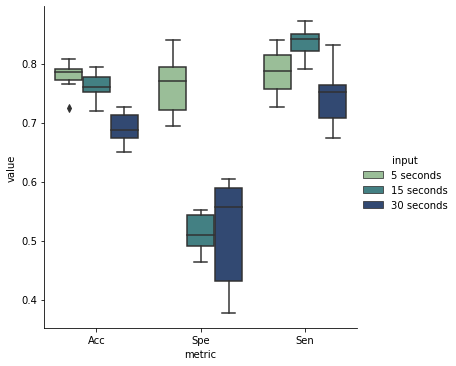

In [95]:
# df = pd.read_csv("E:\\NN\\results_LFP_retrain_crossVal_5.csv")
# df['input'] = '5 seconds'
# df2 =  pd.read_csv("E:\\NN\\results_LFP_retrain_crossVal.csv")
# df2['input'] = '15 seconds'
# df3 =  pd.read_csv("E:\\NN\\results_LFP_retrain_crossVal_30.csv")
# df3['input'] = '30 seconds'
# df = pd.concat([df,df2,df3])
df = df[df.split=='Val']
df_melt = pd.melt(df,id_vars=['itr','input'],value_vars=['Acc','Spe','Sen'],
                  var_name='metric', value_name='value')
sns.catplot(data = df_melt,x='metric',hue='input',y='value',kind='box',palette=a1[0:16:7])#, hue_order=['5','15','30'], showfliers=False)
plt.savefig("E:\\NN\\LFPperformance.svg")


In [93]:
a1 = sns.color_palette("crest",16)
# a1[0:6:2]

In [96]:
model = get_model(segN)
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 1474, 16)          1712      
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 737, 16)           0         
_________________________________________________________________
dropout_120 (Dropout)        (None, 737, 16)           0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 727, 4)            708       
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 363, 4)            0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 363, 4)            0         
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 333, 64)         